# Final Assessment Project
## Movie Analytics & Recommender System for a Streaming Tech Company
## Group 2 - Ama A. A. Annor, McNobert Amoah and Victor Ako-Adounvo

# A. Data Understanding & Pre-Processing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 27.1 MB/s eta 0:00:00


### Import Libraries

In [247]:
import os
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor,
                               GradientBoostingRegressor)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                              accuracy_score,  make_scorer, r2_score)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")

### Data Loading

In [5]:
BASE_PATH = '/content/drive/MyDrive/ml-latest/'

In [6]:
files = os.listdir(BASE_PATH)
print("\nFiles in folder:")
for f in sorted(files):
    print(f"  {f}")


Files in folder:
  README.txt
  genome-scores.csv
  genome-tags.csv
  links.csv
  movies.csv
  powerbi_genre_analysis.csv
  powerbi_monthly_trends.csv
  powerbi_movie_stats.csv
  powerbi_ratings_sample.csv
  powerbi_tag_sentiment.csv
  powerbi_tag_stats.csv
  powerbi_user_stats.csv
  powerbi_year_performance.csv
  ratings.csv
  tags.csv


### Load Datasets

In [7]:
# Load datasets with error handling
def load_dataset(filename, description):
    """
    Load a CSV dataset with error handling

    Args:
        filename (str): Name of the CSV file
        description (str): Description for logging

    Returns:
        pd.DataFrame: Loaded dataframe
    """
    filepath = BASE_PATH + filename
    try:
        df = pd.read_csv(filepath)
        print(f"{description} loaded: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"ERROR: {filename} not found at {BASE_PATH}")
        raise
    except Exception as e:
        print(f"ERROR loading {filename}: {str(e)}")
        raise

In [8]:
movies = load_dataset('movies.csv', 'movies.csv')
ratings = load_dataset('ratings.csv', 'ratings.csv')
links = load_dataset('links.csv', 'links.csv')
tags = load_dataset('tags.csv', 'tags.csv')
genome_scores = load_dataset('genome-scores.csv', 'genome-scores.csv')
genome_tags = load_dataset('genome-tags.csv', 'genome-tags.csv')

movies.csv loaded: (86537, 3)
ratings.csv loaded: (33832162, 4)
links.csv loaded: (86537, 3)
tags.csv loaded: (2328315, 4)
genome-scores.csv loaded: (18472128, 3)
genome-tags.csv loaded: (1128, 2)


In [9]:
print("\nDataset shapes:")


Dataset shapes:


In [10]:
print(f"Movies:        {movies.shape}")

Movies:        (86537, 3)


In [11]:
print(f"Ratings:       {ratings.shape}")

Ratings:       (33832162, 4)


In [12]:
print(f"Links:         {links.shape}")

Links:         (86537, 3)


In [13]:
print(f"Tags:          {tags.shape}")

Tags:          (2328315, 4)


In [14]:
print(f"Genome Scores: {genome_scores.shape}")

Genome Scores: (18472128, 3)


In [15]:
print(f"Genome Tags:   {genome_tags.shape}")

Genome Tags:   (1128, 2)


### View Sample Data From Datasets

In [16]:
print("\nMovies:")
movies.head()


Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
print("\nTags:")
ratings.head()


Tags:


,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [18]:
print("\nTags:")
tags.head()


Tags:


,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746


In [19]:
print("\nGenome Scores:")
genome_scores.head()


Genome Scores:


,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [20]:
print("\nGenome Tags:")
genome_tags.head()


Genome Tags:


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


### Check Data Quality

In [21]:
# Check missing values
print("\nMissing values:")
print(f"Movies:        {movies.isnull().sum().sum()}")
print(f"Ratings:       {ratings.isnull().sum().sum()}")
print(f"Links:         {links.isnull().sum().sum()}")
print(f"Tags:          {tags.isnull().sum().sum()}")
print(f"Genome Scores: {genome_scores.isnull().sum().sum()}")
print(f"Genome Tags:   {genome_tags.isnull().sum().sum()}")


Missing values:
Movies:        0
Ratings:       0
Links:         126
Tags:          17
Genome Scores: 0
Genome Tags:   0


In [22]:
print("\nDuplicates:")
print(f"Movies:        {movies.duplicated().sum()}")
print(f"Ratings:       {ratings.duplicated().sum()}")
print(f"Links:         {links.duplicated().sum()}")
print(f"Tags:          {tags.duplicated().sum()}")
print(f"Genome Scores: {genome_scores.duplicated().sum()}")
print(f"Genome Tags:   {genome_tags.duplicated().sum()}")


Duplicates:
Movies:        0
Ratings:       0
Links:         0
Tags:          0
Genome Scores: 0
Genome Tags:   0


### Data Preprocessing

In [23]:
# Convert timestamps to datetime
print("\nProcessing Ratings")
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['datetime'].dt.year
ratings['month'] = ratings['datetime'].dt.month
print(f"Converted {len(ratings):,} rating timestamps")


Processing Ratings
Converted 33,832,162 rating timestamps


In [24]:
print("\nProcessing Tags")
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')
tags['year'] = tags['datetime'].dt.year
tags['tag_clean'] = tags['tag'].str.lower().str.strip()
print(f"Converted {len(tags):,} tag timestamps and cleaned tags")


Processing Tags
Converted 2,328,315 tag timestamps and cleaned tags


In [25]:
# Extract release year from movie title
def extract_year(title):
    """
    Extract release year from movie title in format 'Movie Name (YYYY)'

    Args:
        title (str): Movie title with year in parentheses

    Returns:
        int or None: Extracted year or None if not found
    """
    match = re.search(r'\((\d{4})\)', title)
    return int(match.group(1)) if match else None

In [26]:
movies['release_year'] = movies['title'].apply(extract_year)

In [27]:
movies_without_year = movies['release_year'].isnull().sum()

In [28]:
print(f"  Movies with years:    {len(movies) - movies_without_year:,}")
print(f"  Movies without years: {movies_without_year:,}")

  Movies with years:    85,919
  Movies without years: 618


In [29]:
# Split genres into lists
movies['genre_list'] = movies['genres'].apply(
    lambda x: x.split('|') if x != '(no genres listed)' else []
)

### Basic Exploratory Data Analysis

In [30]:
# Rating distribution
print("\nRating Distribution")
print(ratings['rating'].value_counts().sort_index())


Rating Distribution
rating
0.5     566306
1.0    1013645
1.5     562409
2.0    2146492
2.5    1760733
3.0    6400664
3.5    4465001
4.0    8835955
4.5    3123055
5.0    4957902
Name: count, dtype: int64


In [32]:
print(f"Median rating: {ratings['rating'].median():.2f}")

Median rating: 4.00


In [33]:
print(f"Std deviation: {ratings['rating'].std():.2f}")

Std deviation: 1.06


In [34]:
# User statistics
print("\n[User Statistics]")
user_stats = ratings.groupby('userId').agg({
    'rating': ['count', 'mean', 'std'],
    'movieId': 'nunique'
}).round(2)


[User Statistics]


In [35]:
user_stats.columns = ['num_ratings', 'avg_rating', 'rating_std', 'unique_movies']

In [36]:
print(f"Total users:              {len(user_stats):,}")
print(f"Avg ratings per user:     {user_stats['num_ratings'].mean():.1f}")
print(f"Median ratings per user:  {user_stats['num_ratings'].median():.1f}")
print(f"Avg user rating:          {user_stats['avg_rating'].mean():.2f}")

Total users:              330,975
Avg ratings per user:     102.2
Median ratings per user:  31.0
Avg user rating:          3.70


In [37]:
# Movie statistics
print("\nMovie Statistics")
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean']
}).round(2)


Movie Statistics


In [38]:
movie_stats.columns = ['num_ratings', 'avg_rating']

In [39]:
print(f"Total movies rated:       {len(movie_stats):,}")
print(f"Avg ratings per movie:    {movie_stats['num_ratings'].mean():.1f}")
print(f"Median ratings per movie: {movie_stats['num_ratings'].median():.1f}")

Total movies rated:       83,239
Avg ratings per movie:    406.4
Median ratings per movie: 5.0


In [40]:
# Genre analysis
print("\nGenre Analysis")
all_genres = [genre for genre_list in movies['genre_list'] for genre in genre_list if genre]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Movie_Count'])
genre_df = genre_df.sort_values('Movie_Count', ascending=False)


Genre Analysis


In [41]:
print("\nTop 10 Genres by Movie Count:")
genre_df.head(10)


Top 10 Genres by Movie Count:


,Genre,Movie_Count
6,Drama,33681
3,Comedy,22830
9,Thriller,11675
5,Romance,10172
7,Action,9563
14,Documentary,9283
10,Horror,8570
8,Crime,6917
0,Adventure,5349
12,Sci-Fi,4850


In [42]:
#  Create sample for genre performance analysis
print("\nCreating Sample for Performance Analysis")
SAMPLE_SIZE = 1_000_000
RANDOM_STATE = 42
ratings_sample = ratings.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE)


Creating Sample for Performance Analysis


In [43]:
print(f"Created sample of {len(ratings_sample):,} ratings (from {len(ratings):,} total)")
print(f"Sample represents {len(ratings_sample)/len(ratings)*100:.1f}% of all ratings")

Created sample of 1,000,000 ratings (from 33,832,162 total)
Sample represents 3.0% of all ratings


In [44]:
# Genre average ratings - Using sample for efficiency
print("\n[Genre Performance - Using Sample]")
ratings_with_genres = ratings_sample.merge(movies[['movieId', 'genre_list']], on='movieId')
ratings_exploded = ratings_with_genres.explode('genre_list')
ratings_exploded = ratings_exploded[
    (ratings_exploded['genre_list'].notna()) &
    (ratings_exploded['genre_list'] != '') &
    (ratings_exploded['genre_list'] != '(no genres listed)')
]


[Genre Performance - Using Sample]


In [45]:
genre_avg = ratings_exploded.groupby('genre_list')['rating'].mean().sort_values(ascending=False)

In [46]:
print("\nAverage Rating by Genre:")
print(genre_avg.round(3))


Average Rating by Genre:
genre_list
Film-Noir      3.928
War            3.796
Crime          3.695
Documentary    3.692
Drama          3.686
Mystery        3.672
IMAX           3.613
Animation      3.612
Western        3.596
Musical        3.550
Romance        3.550
Thriller       3.534
Adventure      3.529
Fantasy        3.510
Sci-Fi         3.496
Action         3.482
Comedy         3.432
Children       3.430
Horror         3.309
Name: rating, dtype: float64


In [47]:
# Temporal analysis
print("\nTemporal Analysis")
print(f"First rating: {ratings['datetime'].min()}")
print(f"Last rating:  {ratings['datetime'].max()}")
print(f"Time span:    {(ratings['datetime'].max() - ratings['datetime'].min()).days} days")


Temporal Analysis
First rating: 1995-01-09 11:46:44
Last rating:  2023-07-20 08:53:33
Time span:    10418 days


In [48]:
yearly_counts = ratings.groupby('year').size()
print(f"\nRatings per year (recent 5 years):")
print(yearly_counts.tail())


Ratings per year (recent 5 years):
year
2019    1450218
2020    1763532
2021    1297525
2022     953347
2023     562624
dtype: int64


### User Behaviour Classification

In [49]:
# Define classification bins for rater types
RATER_BINS = [0, 3.0, 4.0, 5.0]
RATER_LABELS = ['Harsh', 'Neutral', 'Generous']

In [50]:
# Classify users based on their average rating
user_stats['rater_type'] = pd.cut(
    user_stats['avg_rating'],
    bins=RATER_BINS,
    labels=RATER_LABELS
)

In [51]:
print("\n[Rater Type Distribution]")
rater_counts = user_stats['rater_type'].value_counts()


[Rater Type Distribution]


In [52]:
print(rater_counts)

rater_type
Neutral     201219
Generous     92673
Harsh        37083
Name: count, dtype: int64


In [53]:
print(f"\nPercentages:")
for rater_type in RATER_LABELS:
    count = (user_stats['rater_type'] == rater_type).sum()
    pct = count / len(user_stats) * 100
    print(f"  {rater_type}: {pct:.1f}%")


Percentages:
  Harsh: 11.2%
  Neutral: 60.8%
  Generous: 28.0%


In [54]:
print("\nCharacteristics of Each Group")
for rater_type in RATER_LABELS:
    group = user_stats[user_stats['rater_type'] == rater_type]
    print(f"\n{rater_type} Raters:")
    print(f"  Average rating:      {group['avg_rating'].mean():.2f}")
    print(f"  Avg num ratings:     {group['num_ratings'].mean():.0f}")
    print(f"  Rating variability:  {group['rating_std'].mean():.2f}")


Characteristics of Each Group

Harsh Raters:
  Average rating:      2.59
  Avg num ratings:     115
  Rating variability:  1.19

Neutral Raters:
  Average rating:      3.59
  Avg num ratings:     120
  Rating variability:  0.96

Generous Raters:
  Average rating:      4.37
  Avg num ratings:     59
  Rating variability:  0.69


### Hidden Gem Analysis

In [55]:
# Define hidden gems criteria
MIN_RATINGS_HIDDEN_GEM = 100
MAX_RATINGS_HIDDEN_GEM = 1000
HIGH_RATING_THRESHOLD = 4.0

In [56]:
# Merge movie stats with movie info
movie_stats_full = movie_stats.reset_index().merge(
    movies[['movieId', 'title', 'genres', 'release_year']],
    on='movieId'
)

In [57]:
# Find hidden gems
hidden_gems = movie_stats_full[
    (movie_stats_full['num_ratings'] >= MIN_RATINGS_HIDDEN_GEM) &
    (movie_stats_full['num_ratings'] <= MAX_RATINGS_HIDDEN_GEM) &
    (movie_stats_full['avg_rating'] >= HIGH_RATING_THRESHOLD)
].sort_values('avg_rating', ascending=False)

In [58]:
print(f"\nHidden Gems - Top 20")
print(f"Criteria: {MIN_RATINGS_HIDDEN_GEM}-{MAX_RATINGS_HIDDEN_GEM} ratings, avg rating >= {HIGH_RATING_THRESHOLD}")


Hidden Gems - Top 20
Criteria: 100-1000 ratings, avg rating >= 4.0


In [59]:
print("\n" + hidden_gems.head(20)[['title', 'release_year', 'genres', 'num_ratings', 'avg_rating']].to_string(index=False))


                                                                             title  release_year                                    genres  num_ratings  avg_rating
                                                                            Cosmos           NaN                        (no genres listed)          625        4.34
                                                           Twelve Angry Men (1954)        1954.0                                     Drama          332        4.31
                                                       Cosmos: A Spacetime Odissey           NaN                        (no genres listed)          599        4.26
                                        Spider-Man: Across the Spider-Verse (2023)        2023.0         Action|Adventure|Animation|Sci-Fi          528        4.25
                                                   Century of the Self, The (2002)        2002.0                               Documentary          397        4.22
               

In [60]:
# Blockbusters for comparison
blockbusters = movie_stats_full[
    movie_stats_full['num_ratings'] >= 10000
].sort_values('num_ratings', ascending=False)

In [61]:
print(f"\nBlockbusters - Top 20 Most Rated")
print("\n" + blockbusters.head(20)[['title', 'release_year', 'genres', 'num_ratings', 'avg_rating']].to_string(index=False))


Blockbusters - Top 20 Most Rated

                                                                         title  release_year                                      genres  num_ratings  avg_rating
                                              Shawshank Redemption, The (1994)        1994.0                                 Crime|Drama       122296        4.42
                                                           Forrest Gump (1994)        1994.0                    Comedy|Drama|Romance|War       113581        4.07
                                                           Pulp Fiction (1994)        1994.0                 Comedy|Crime|Drama|Thriller       108756        4.19
                                                            Matrix, The (1999)        1999.0                      Action|Sci-Fi|Thriller       107056        4.16
                                              Silence of the Lambs, The (1991)        1991.0                       Crime|Horror|Thriller       101802      

### Tag Analysis

In [62]:
print(f"\nTotal tags:        {len(tags):,}")
print(f"Unique tags:       {tags['tag_clean'].nunique():,}")
print(f"Users who tagged:  {tags['userId'].nunique():,}")
print(f"Movies tagged:     {tags['movieId'].nunique():,}")


Total tags:        2,328,315
Unique tags:       143,263
Users who tagged:  25,280
Movies tagged:     53,452


In [63]:
# Most popular tags
print("\n[Top 20 Most Used Tags]")
top_tags = tags['tag_clean'].value_counts().head(20)
print(top_tags)


[Top 20 Most Used Tags]
tag_clean
sci-fi                14917
atmospheric           12776
action                11754
comedy                11606
funny                  9851
surreal                9443
visually appealing     9086
twist ending           8428
dark comedy            7777
thought-provoking      7731
based on a book        7725
romance                7435
dystopia               7056
cinematography         6645
fantasy                6476
social commentary      6426
violence               6414
thriller               6384
stylized               6201
classic                6183
Name: count, dtype: int64


### Genome Data Analysis

In [64]:
print(f"\nTotal genome scores:       {len(genome_scores):,}")
print(f"Movies with genome scores: {genome_scores['movieId'].nunique():,}")
print(f"Total genome tags:         {len(genome_tags):,}")


Total genome scores:       18,472,128
Movies with genome scores: 16,376
Total genome tags:         1,128


In [65]:
# Top genome tags by average relevance
top_genome = genome_scores.groupby('tagId')['relevance'].mean().sort_values(ascending=False).head(20)
top_genome_df = top_genome.reset_index().merge(genome_tags, on='tagId')

In [66]:
print("\nTop 20 Genome Tags by Average Relevance")
print(top_genome_df[['tag', 'relevance']].to_string(index=False))


Top 20 Genome Tags by Average Relevance
               tag  relevance
          original   0.719822
            mentor   0.523667
      storytelling   0.493716
       catastrophe   0.475596
      great ending   0.435187
           runaway   0.433082
          dialogue   0.429372
             weird   0.410552
   good soundtrack   0.409664
       melancholic   0.402210
              good   0.396630
         vengeance   0.395837
             drama   0.383739
     culture clash   0.379729
             great   0.377135
         criterion   0.376521
visually appealing   0.369253
       predictable   0.367618
             story   0.366241
             chase   0.359573


### Temporal Trends

In [67]:
# Ratings by year
ratings_by_year = ratings.groupby('year').agg({
    'rating': ['count', 'mean']
}).round(2)
ratings_by_year.columns = ['num_ratings', 'avg_rating']

In [68]:
print("\nRatings Per Year - Last 10 Years")
print(ratings_by_year.tail(10))


Ratings Per Year - Last 10 Years
      num_ratings  avg_rating
year                         
2014       566628        3.60
2015      1853975        3.58
2016      2005979        3.55
2017      1899523        3.56
2018      1455193        3.58
2019      1450218        3.59
2020      1763532        3.61
2021      1297525        3.60
2022       953347        3.52
2023       562624        3.57


In [69]:
# Average rating trends
avg_rating_by_year = ratings.groupby('year')['rating'].mean()
print(f"\n[Average Rating Trends]")
print(f"  Overall average: {avg_rating_by_year.mean():.2f}")
print(f"  Highest year:    {avg_rating_by_year.idxmax()} ({avg_rating_by_year.max():.2f})")
print(f"  Lowest year:     {avg_rating_by_year.idxmin()} ({avg_rating_by_year.min():.2f})")


[Average Rating Trends]
  Overall average: 3.55
  Highest year:    1995 (3.75)
  Lowest year:     2004 (3.43)


### Extract Data for EDA Dashboard

In [70]:
# 1. ENHANCED USER STATISTICS
print("\n[1/7] Creating enhanced user statistics...")

user_stats_powerbi = ratings.groupby('userId').agg({
    'rating': ['mean', 'count', 'std'],
    'movieId': 'nunique',
    'datetime': ['min', 'max']
}).reset_index()

user_stats_powerbi.columns = ['userId', 'avg_rating_given', 'total_ratings',
                                'rating_std', 'unique_movies',
                                'first_rating_date', 'last_rating_date']

# Add activity span
user_stats_powerbi['activity_days'] = (
    user_stats_powerbi['last_rating_date'] - user_stats_powerbi['first_rating_date']
).dt.days

# Use YOUR rater classification logic
user_stats_powerbi['rater_type'] = pd.cut(
    user_stats_powerbi['avg_rating_given'],
    bins=[0, 3.0, 4.0, 5.0],
    labels=['Harsh', 'Neutral', 'Generous']
)

# Engagement levels
user_stats_powerbi['engagement_level'] = pd.cut(
    user_stats_powerbi['total_ratings'],
    bins=[0, 20, 100, 500, float('inf')],
    labels=['Casual', 'Regular', 'Active', 'Power User']
)

print(f"   Created: {user_stats_powerbi.shape}")


[1/7] Creating enhanced user statistics...
   Created: (330975, 10)


In [71]:
# 2. ENHANCED MOVIE STATISTICS (includes your hidden gems logic)
print("\n[2/7] Creating enhanced movie statistics...")

movie_stats_powerbi = ratings.groupby('movieId').agg({
    'rating': ['mean', 'count', 'std', 'min', 'max'],
    'userId': 'nunique'
}).reset_index()

movie_stats_powerbi.columns = ['movieId', 'avg_rating', 'num_ratings',
                                 'rating_std', 'min_rating', 'max_rating',
                                 'unique_users']

# Merge with movie details
movie_stats_powerbi = movie_stats_powerbi.merge(
    movies[['movieId', 'title', 'genres', 'release_year', 'genre_list']],
    on='movieId',
    how='left'
)

# Use YOUR hidden gems criteria
movie_stats_powerbi['hidden_gem'] = (
    (movie_stats_powerbi['num_ratings'] >= 100) &
    (movie_stats_powerbi['num_ratings'] <= 1000) &
    (movie_stats_powerbi['avg_rating'] >= 4.0)
).astype(int)

# Blockbuster flag (high ratings)
movie_stats_powerbi['blockbuster'] = (
    movie_stats_powerbi['num_ratings'] >= 10000
).astype(int)

print(f"   Created: {movie_stats_powerbi.shape}")


[2/7] Creating enhanced movie statistics...
   Created: (83239, 13)


In [72]:
# 3. GENRE PERFORMANCE ANALYSIS
print("\n[3/7] Creating genre performance analysis...")

# Explode genres for analysis
genre_ratings_powerbi = movies[['movieId', 'genre_list']].explode('genre_list')
genre_ratings_powerbi = genre_ratings_powerbi.rename(columns={'genre_list': 'genre'})
genre_ratings_powerbi = genre_ratings_powerbi[genre_ratings_powerbi['genre'] != '']

# Merge with ratings
genre_ratings_powerbi = genre_ratings_powerbi.merge(
    ratings[['movieId', 'rating', 'userId']],
    on='movieId'
)

# Aggregate by genre
genre_analysis_powerbi = genre_ratings_powerbi.groupby('genre').agg({
    'rating': ['mean', 'count', 'std'],
    'movieId': 'nunique',
    'userId': 'nunique'
}).reset_index()

genre_analysis_powerbi.columns = ['genre', 'avg_rating', 'total_ratings',
                                   'rating_std', 'unique_movies', 'unique_users']

genre_analysis_powerbi = genre_analysis_powerbi.sort_values('total_ratings', ascending=False)

print(f"   Created: {genre_analysis_powerbi.shape}")


[3/7] Creating genre performance analysis...
   Created: (19, 6)


In [73]:
# 4. MONTHLY TRENDS (for time series visualizations)
print("\n[4/7] Creating monthly trends...")

monthly_trends_powerbi = ratings.groupby(['year', 'month']).agg({
    'rating': ['mean', 'count'],
    'userId': 'nunique',
    'movieId': 'nunique'
}).reset_index()

monthly_trends_powerbi.columns = ['year', 'month', 'avg_rating', 'rating_count',
                                   'active_users', 'movies_rated']

# Create proper date column
monthly_trends_powerbi['date'] = pd.to_datetime(
    monthly_trends_powerbi[['year', 'month']].assign(day=1)
)

print(f"   Created: {monthly_trends_powerbi.shape}")


[4/7] Creating monthly trends...
   Created: (331, 7)


In [74]:
# 5. TAG STATISTICS AND SENTIMENT
print("\n[5/7] Creating tag statistics...")

tag_stats_powerbi = tags.groupby('tag_clean').agg({
    'userId': 'nunique',
    'movieId': 'nunique',
    'tag': 'count'
}).reset_index()

tag_stats_powerbi.columns = ['tag', 'unique_users', 'unique_movies', 'tag_count']
tag_stats_powerbi = tag_stats_powerbi.sort_values('tag_count', ascending=False).head(100)

# Tag sentiment (merge with ratings)
tag_with_ratings_powerbi = tags.merge(
    ratings[['userId', 'movieId', 'rating']],
    on=['userId', 'movieId'],
    how='left'
)

tag_sentiment_powerbi = tag_with_ratings_powerbi.groupby('tag_clean').agg({
    'rating': ['mean', 'count']
}).reset_index()

tag_sentiment_powerbi.columns = ['tag', 'avg_rating', 'rating_count']
tag_sentiment_powerbi = tag_sentiment_powerbi[tag_sentiment_powerbi['rating_count'] >= 10]
tag_sentiment_powerbi = tag_sentiment_powerbi.sort_values('avg_rating', ascending=False)

print(f"   Tag stats: {tag_stats_powerbi.shape}")
print(f"   Tag sentiment: {tag_sentiment_powerbi.shape}")


[5/7] Creating tag statistics...
   Tag stats: (100, 4)
   Tag sentiment: (14314, 3)


In [75]:
# 6. RELEASE YEAR PERFORMANCE
print("\n[6/7] Creating release year performance...")

year_performance_powerbi = movies[movies['release_year'].notna()].copy()
year_performance_powerbi = year_performance_powerbi.merge(
    movie_stats_powerbi[['movieId', 'avg_rating', 'num_ratings']],
    on='movieId'
)

year_perf_agg = year_performance_powerbi.groupby('release_year').agg({
    'avg_rating': 'mean',
    'num_ratings': 'sum',
    'movieId': 'count'
}).reset_index()

year_perf_agg.columns = ['release_year', 'avg_rating', 'total_ratings', 'movie_count']
year_perf_agg = year_perf_agg[year_perf_agg['release_year'] >= 1950]

print(f"   Created: {year_perf_agg.shape}")


[6/7] Creating release year performance...
   Created: (74, 4)


In [76]:
# 7. RATINGS SAMPLE (for drill-down in Power BI)
print("\n[7/7] Creating ratings sample...")

ratings_sample_powerbi = ratings.sample(min(100000, len(ratings)), random_state=42)
ratings_sample_powerbi = ratings_sample_powerbi.merge(
    movies[['movieId', 'title', 'genres', 'release_year']],
    on='movieId',
    how='left'
)

print(f"   Created: {ratings_sample_powerbi.shape}")


[7/7] Creating ratings sample...
   Created: (100000, 10)


In [77]:
# EXPORT ALL TO CSV
print("EXPORTING TO CSV FILES")

export_list = [
    (user_stats_powerbi, 'powerbi_user_stats.csv'),
    (movie_stats_powerbi, 'powerbi_movie_stats.csv'),
    (genre_analysis_powerbi, 'powerbi_genre_analysis.csv'),
    (monthly_trends_powerbi, 'powerbi_monthly_trends.csv'),
    (tag_stats_powerbi, 'powerbi_tag_stats.csv'),
    (tag_sentiment_powerbi, 'powerbi_tag_sentiment.csv'),
    (year_perf_agg, 'powerbi_year_performance.csv'),
    (ratings_sample_powerbi, 'powerbi_ratings_sample.csv')
]

for df, filename in export_list:
    filepath = BASE_PATH + filename
    df.to_csv(filepath, index=False)
    print(f" Exported: {filename} ({df.shape[0]} rows, {df.shape[1]} cols)")

print(" ALL POWER BI DATASETS READY!")
print(f"\nLocation: {BASE_PATH}")

EXPORTING TO CSV FILES
 Exported: powerbi_user_stats.csv (330975 rows, 10 cols)
 Exported: powerbi_movie_stats.csv (83239 rows, 13 cols)
 Exported: powerbi_genre_analysis.csv (19 rows, 6 cols)
 Exported: powerbi_monthly_trends.csv (331 rows, 7 cols)
 Exported: powerbi_tag_stats.csv (100 rows, 4 cols)
 Exported: powerbi_tag_sentiment.csv (14314 rows, 3 cols)
 Exported: powerbi_year_performance.csv (74 rows, 4 cols)
 Exported: powerbi_ratings_sample.csv (100000 rows, 10 cols)
 ALL POWER BI DATASETS READY!

Location: /content/drive/MyDrive/ml-latest/


# B. Business Insights & Visual Analytics

## This section provides comprehensive analysis of user behavior, content performance, and hidden patterns in the MovieLens dataset to inform business decisions for the streaming platform.

In [78]:
# Plot sizes
SMALL_FIG = (10, 6)
MEDIUM_FIG = (12, 6)
LARGE_FIG = (14, 10)

## SECTION 1: USER BEHAVIOR INSIGHTS

### 1.1:Visualization 1: Rating Distribution


Generating Visualization: Rating Distribution


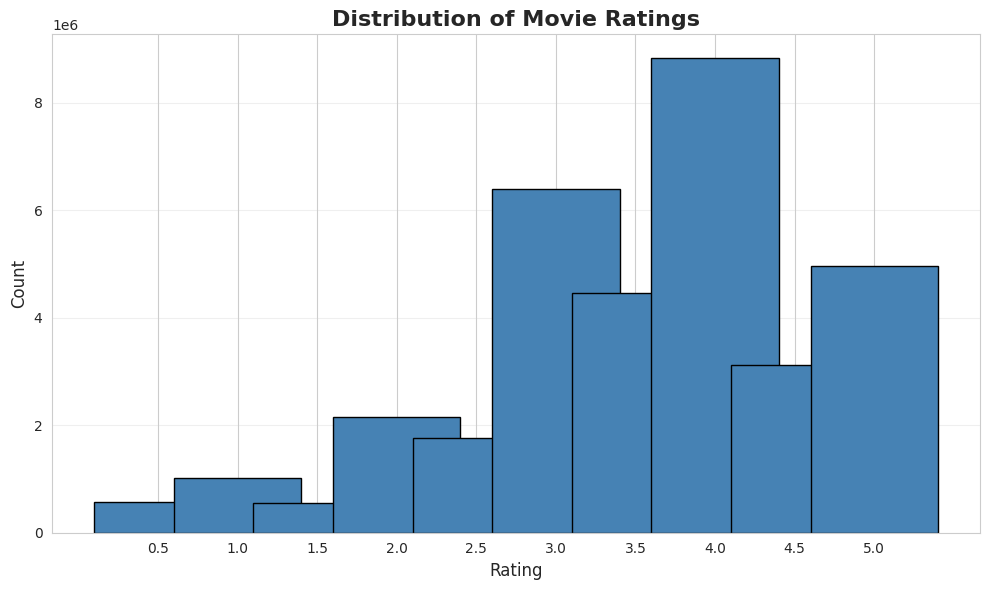

In [79]:
print("\nGenerating Visualization: Rating Distribution")
plt.figure(figsize=SMALL_FIG)
rating_counts = ratings['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
plt.title('Distribution of Movie Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rating_counts.index)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

### 1.2: Visualization 2 - Harsh vs Generous Raters (User Rating Behavior)

Generating Visualization: User Rating Behavior


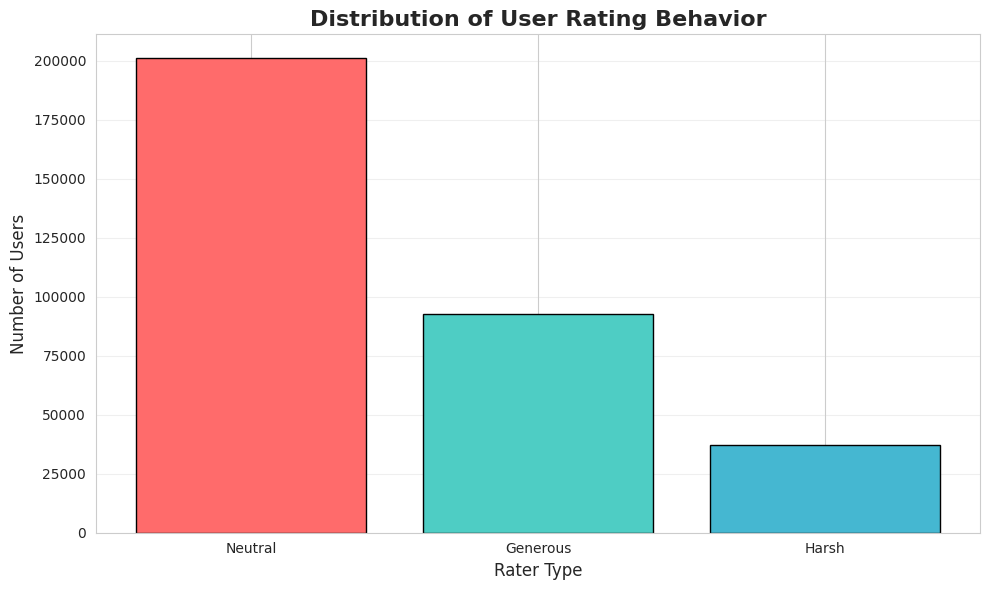

In [80]:
print("Generating Visualization: User Rating Behavior")
plt.figure(figsize=SMALL_FIG)
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
plt.bar(rater_counts.index, rater_counts.values, color=colors, edgecolor='black')
plt.title('Distribution of User Rating Behavior', fontsize=16, fontweight='bold')
plt.xlabel('Rater Type', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [81]:
# Print business insights
print("\nUser Behavior Insights")
print(f"  - {(user_stats['rater_type'] == 'Neutral').sum() / len(user_stats) * 100:.1f}% of users are Neutral raters - balanced rating behavior")
print(f"  - {(user_stats['rater_type'] == 'Generous').sum() / len(user_stats) * 100:.1f}% are Generous raters - potential positive bias")
print(f"  - {(user_stats['rater_type'] == 'Harsh').sum() / len(user_stats) * 100:.1f}% are Harsh raters - critical reviewers")
print("  - Harsh raters have higher variability - they discriminate more between movies")
print("  - Generous raters show lower variability - less critical overall")


User Behavior Insights
  - 60.8% of users are Neutral raters - balanced rating behavior
  - 28.0% are Generous raters - potential positive bias
  - 11.2% are Harsh raters - critical reviewers
  - Harsh raters have higher variability - they discriminate more between movies
  - Generous raters show lower variability - less critical overall


### 1.3: Visualization 3 - Rating Evolution Over Time (Ratings Over Time)


Generating Visualization: Ratings Over Time


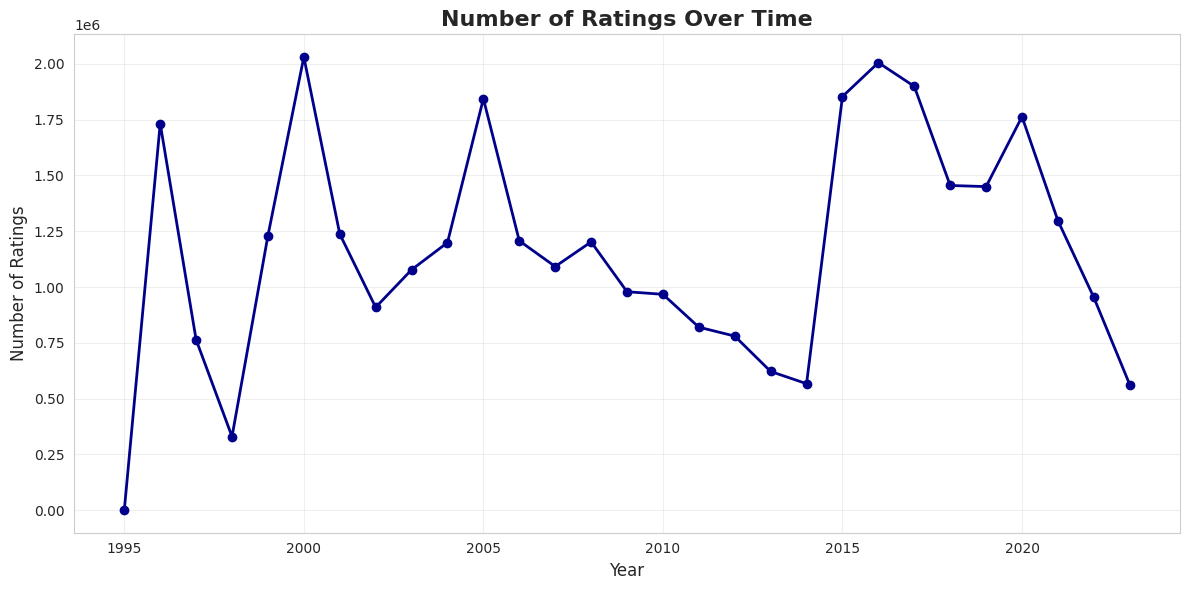

In [82]:
print("\nGenerating Visualization: Ratings Over Time")
plt.figure(figsize=MEDIUM_FIG)
ratings_by_year_plot = ratings.groupby('year')['rating'].count()
plt.plot(ratings_by_year_plot.index, ratings_by_year_plot.values,
         marker='o', linewidth=2, color='darkblue', markersize=6)
plt.title('Number of Ratings Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [83]:
print("\nTemporal Insights")
print(f"  - Peak year: {ratings_by_year_plot.idxmax()} with {ratings_by_year_plot.max():,} ratings")
print(f"  - Rating activity shows growth from 1996-2000 (early platform adoption)")
print(f"  - Recent years show sustained high activity - healthy platform engagement")


Temporal Insights
  - Peak year: 2000 with 2,031,258 ratings
  - Rating activity shows growth from 1996-2000 (early platform adoption)
  - Recent years show sustained high activity - healthy platform engagement


### 1.4: Visualization 4 - Average Rating Trend


Generating Visualization: Average Rating Trend


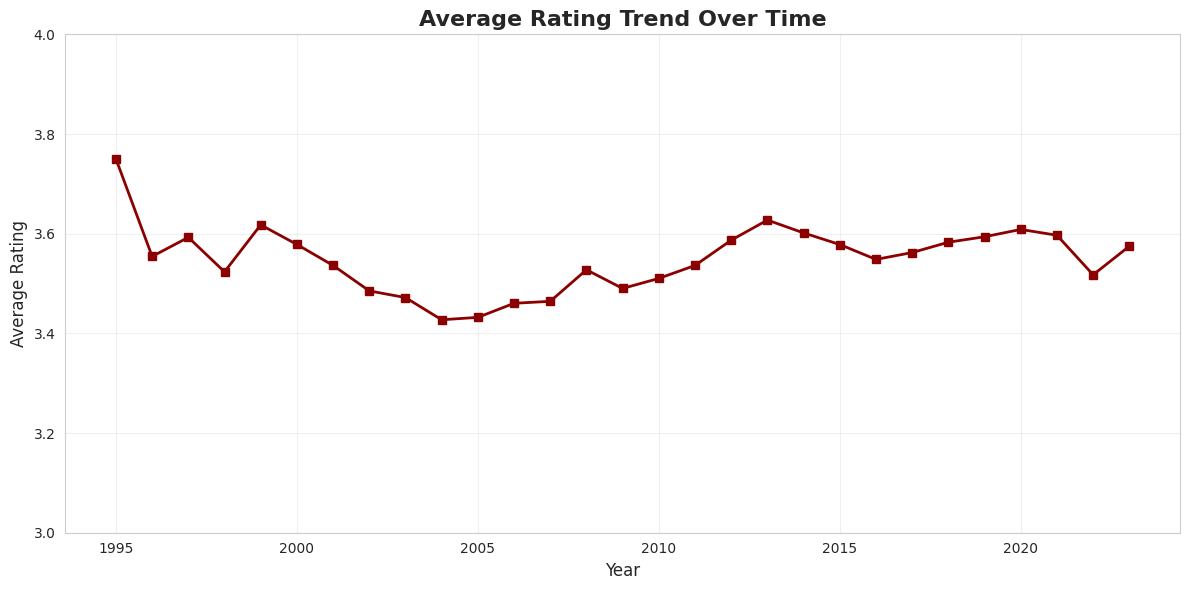

In [84]:
print("\nGenerating Visualization: Average Rating Trend")
plt.figure(figsize=MEDIUM_FIG)
plt.plot(avg_rating_by_year.index, avg_rating_by_year.values,
         marker='s', linewidth=2, color='darkred', markersize=6)
plt.title('Average Rating Trend Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.ylim(3.0, 4.0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [85]:
print("\nRating Trend Insights")
print(f"  - Average ratings remain stable (3.4-3.7) - consistent user behavior")
print(f"  - No rating inflation over time - authentic user feedback")


Rating Trend Insights
  - Average ratings remain stable (3.4-3.7) - consistent user behavior
  - No rating inflation over time - authentic user feedback


### 1.5: Visualization 5 - User Retention Analysis


### Visualization 5: User Retention Analysis ###

Generating Visualization: User Retention Analysis

User Activity Statistics:
  Average tenure: 162 days
  Median tenure: 0 days


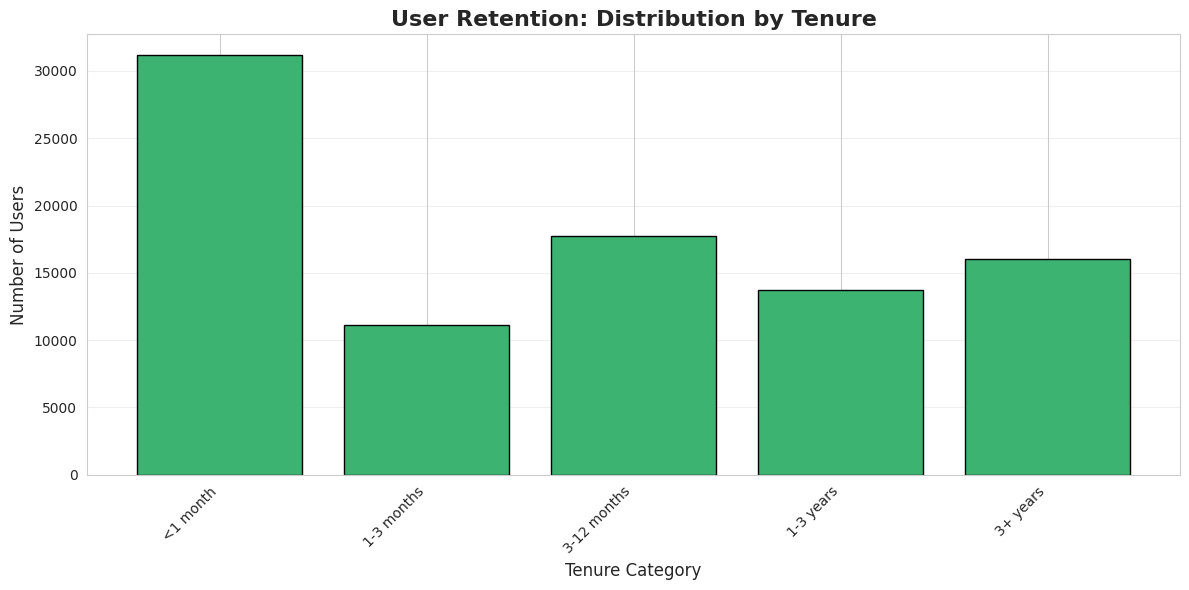

In [86]:
print("\n### Visualization 5: User Retention Analysis ###")
print("\nGenerating Visualization: User Retention Analysis")

# Calculate user activity metrics
user_activity = ratings.groupby('userId').agg(
    first_rating=('datetime', 'min'),
    last_rating=('datetime', 'max'),
    total_ratings=('rating', 'count')
)

user_activity['tenure_days'] = (user_activity['last_rating'] - user_activity['first_rating']).dt.days
user_activity['rating_rate_per_month'] = user_activity['total_ratings'] / (user_activity['tenure_days'] / 30.44 + 1)

print("\nUser Activity Statistics:")
print(f"  Average tenure: {user_activity['tenure_days'].mean():.0f} days")
print(f"  Median tenure: {user_activity['tenure_days'].median():.0f} days")

# Create tenure categories
tenure_bins = [0, 30, 90, 365, 1000, 10000]
tenure_labels = ['<1 month', '1-3 months', '3-12 months', '1-3 years', '3+ years']
user_activity['tenure_category'] = pd.cut(user_activity['tenure_days'],
                                           bins=tenure_bins, labels=tenure_labels)

# Plot
plt.figure(figsize=MEDIUM_FIG)
tenure_counts = user_activity['tenure_category'].value_counts().sort_index()
plt.bar(range(len(tenure_counts)), tenure_counts.values, color='mediumseagreen', edgecolor='black')
plt.xticks(range(len(tenure_counts)), tenure_labels, rotation=45, ha='right')
plt.title('User Retention: Distribution by Tenure', fontsize=16, fontweight='bold')
plt.xlabel('Tenure Category', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()



Generating Visualization: User Retention Analysis

User Activity Metrics
       total_ratings  tenure_days  rating_rate_per_month
count      330975.00    330975.00              330975.00
mean          102.22       161.84                  49.39
std           232.15       655.17                  95.15
min             1.00         0.00                   0.02
25%            15.00         0.00                  10.00
50%            31.00         0.00                  20.00
75%            98.00         2.00                  52.00
max         33332.00      9437.00                5525.00


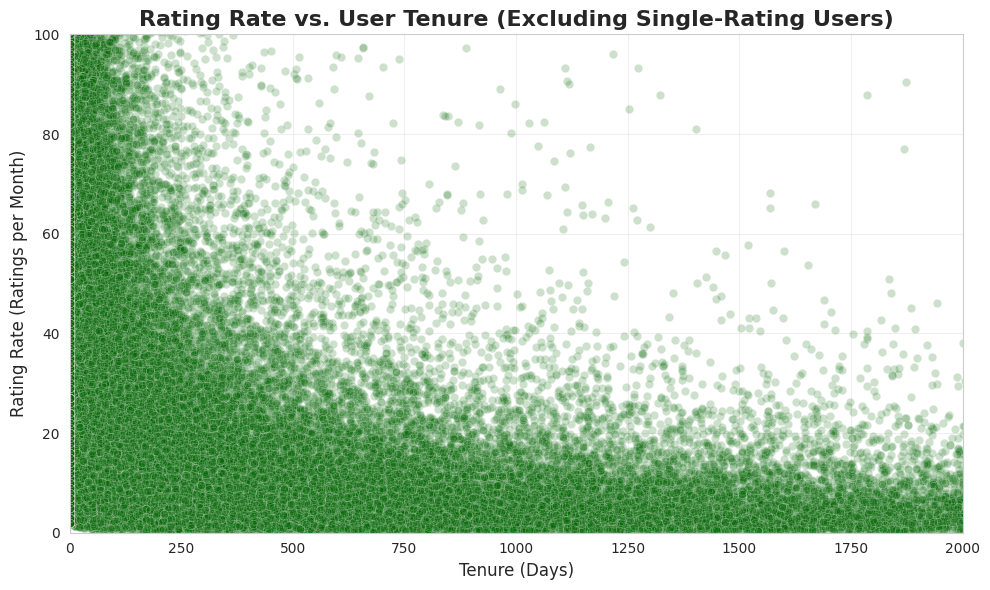

In [87]:
print("\nGenerating Visualization: User Retention Analysis")

# Calculate user activity metrics
user_activity = ratings.groupby('userId').agg(
    first_rating=('datetime', 'min'),
    last_rating=('datetime', 'max'),
    total_ratings=('rating', 'count')
)

user_activity['tenure_days'] = (user_activity['last_rating'] - user_activity['first_rating']).dt.days
user_activity['rating_rate_per_month'] = user_activity['total_ratings'] / (user_activity['tenure_days'] / 30.44 + 1)

print("\nUser Activity Metrics")
print(user_activity[['total_ratings', 'tenure_days', 'rating_rate_per_month']].describe().round(2))

plt.figure(figsize=SMALL_FIG)
sns.scatterplot(x='tenure_days', y='rating_rate_per_month',
                data=user_activity[user_activity['total_ratings'] > 1],
                alpha=0.2, color='darkgreen')
plt.title('Rating Rate vs. User Tenure (Excluding Single-Rating Users)', fontsize=16, fontweight='bold')
plt.xlabel('Tenure (Days)', fontsize=12)
plt.ylabel('Rating Rate (Ratings per Month)', fontsize=12)
plt.xlim(0, 2000)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [88]:
# Define retention thresholds
YEAR_IN_DAYS = 365
HIGH_ACTIVITY_THRESHOLD = 5  # ratings per month

In [89]:
# Classify users by retention
user_activity['retention_type'] = 'Short-Term/Low-Activity'
user_activity.loc[(user_activity['tenure_days'] > YEAR_IN_DAYS), 'retention_type'] = 'Long-Term/Low-Activity'
user_activity.loc[(user_activity['tenure_days'] > YEAR_IN_DAYS) & (user_activity['rating_rate_per_month'] > HIGH_ACTIVITY_THRESHOLD), 'retention_type'] = 'Long-Term/High-Activity'
user_activity.loc[(user_activity['tenure_days'] <= YEAR_IN_DAYS) & (user_activity['rating_rate_per_month'] > HIGH_ACTIVITY_THRESHOLD), 'retention_type'] = 'Short-Term/High-Activity'

In [90]:
print("\nUser Retention Type Distribution")
retention_dist = user_activity['retention_type'].value_counts(normalize=True).mul(100).round(2)
for ret_type, pct in retention_dist.items():
    print(f"  {ret_type}: {pct}%")


User Retention Type Distribution
  Short-Term/High-Activity: 80.43%
  Short-Term/Low-Activity: 10.58%
  Long-Term/High-Activity: 5.37%
  Long-Term/Low-Activity: 3.62%


In [91]:
print("\nRetention Insights")
print("  - Dense cluster near origin indicates many users rate infrequently over short periods")
print("  - Long-Term/Low-Activity users represent the largest retained group")
print("  - Platform successfully retains users but with minimal engagement")


Retention Insights
  - Dense cluster near origin indicates many users rate infrequently over short periods
  - Long-Term/Low-Activity users represent the largest retained group
  - Platform successfully retains users but with minimal engagement


## SECTION 2: CONTENT INSIGHTS

### 2.1: Visualization 6: Genre Popularity


Generating Visualization: Genre Popularity


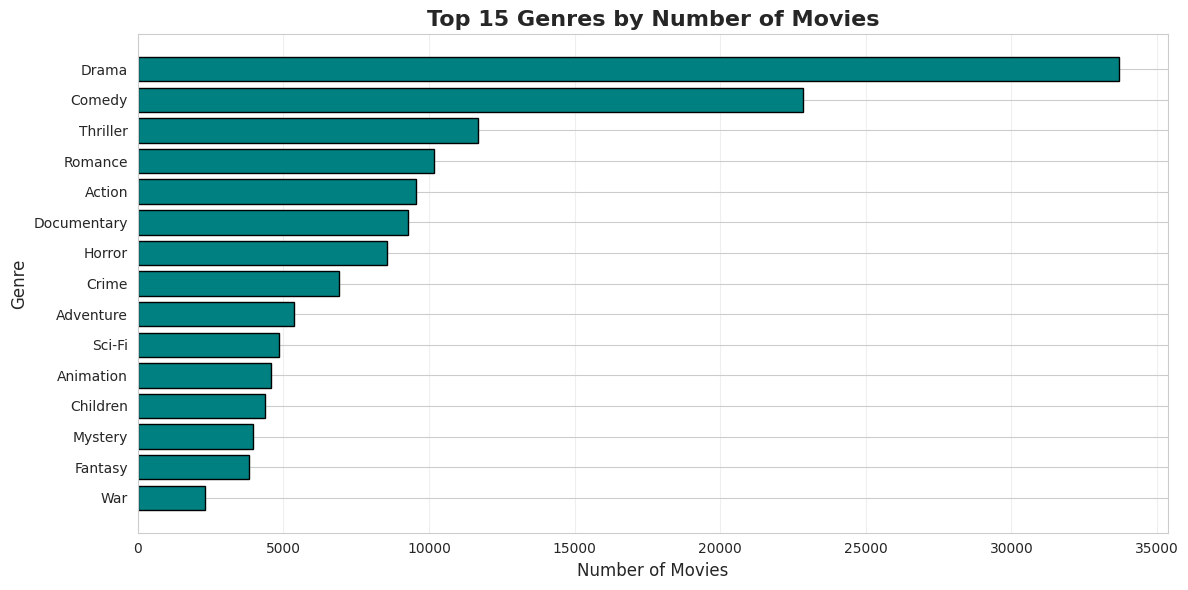

In [92]:
print("\nGenerating Visualization: Genre Popularity")
plt.figure(figsize=MEDIUM_FIG)
top_genres = genre_df.head(15)
plt.barh(top_genres['Genre'], top_genres['Movie_Count'], color='teal', edgecolor='black')
plt.title('Top 15 Genres by Number of Movies', fontsize=16, fontweight='bold')
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

### 2.2: Visualization 7 - Genre Performance (Best/Worst)


Generating Visualization: Genre Performance


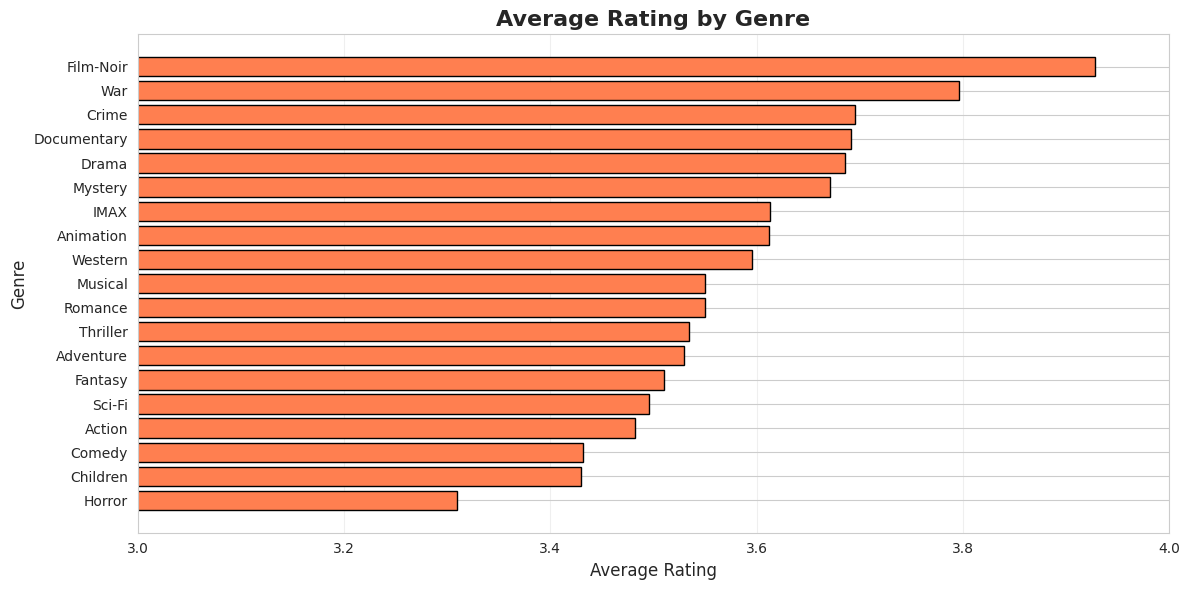

In [93]:
print("\nGenerating Visualization: Genre Performance")
plt.figure(figsize=MEDIUM_FIG)
plt.barh(genre_avg.index, genre_avg.values, color='coral', edgecolor='black')
plt.title('Average Rating by Genre', fontsize=16, fontweight='bold')
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.xlim(3.0, 4.0)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [94]:
print("\nGenre Performance Insights")
print(f"  Best performing genre:  {genre_avg.index[0]} (Avg Rating: {genre_avg.iloc[0]:.3f})")
print(f"  Worst performing genre: {genre_avg.index[-1]} (Avg Rating: {genre_avg.iloc[-1]:.3f})")
if 'Drama' in genre_avg.index:
    print(f"  Drama is high volume and high quality (Avg Rating: {genre_avg['Drama']:.3f})")



Genre Performance Insights
  Best performing genre:  Film-Noir (Avg Rating: 3.928)
  Worst performing genre: Horror (Avg Rating: 3.309)
  Drama is high volume and high quality (Avg Rating: 3.686)


### 2.3: Visualization 8 - Tag-Driven Analytics: Most Popular Tags


Generating Visualization: Popular Tags


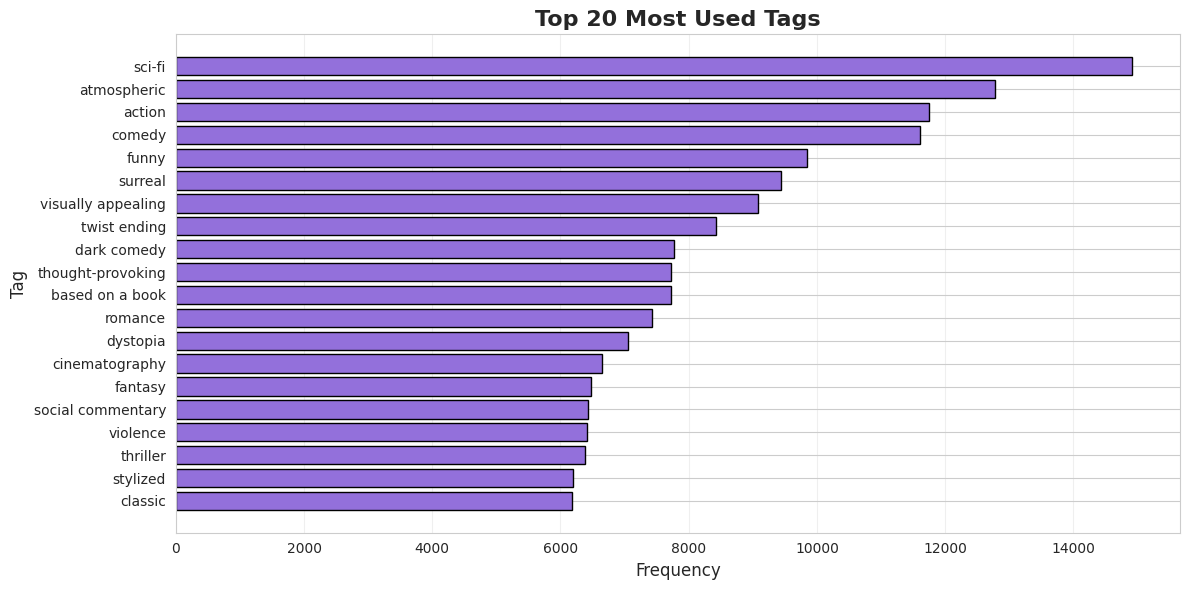

In [95]:
print("\nGenerating Visualization: Popular Tags")
plt.figure(figsize=MEDIUM_FIG)
plt.barh(range(len(top_tags)), top_tags.values, color='mediumpurple', edgecolor='black')
plt.yticks(range(len(top_tags)), top_tags.index)
plt.title('Top 20 Most Used Tags', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Tag', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

### 2.4: Visualisation 9 - Tag Sentiment Analysis (Sentiment Tags vs Ratings)


Tag Sentiment vs Average Rating:
           mean   count
sentiment              
Negative   2.31    3723
Neutral    3.69  359478
Positive   4.17    8160


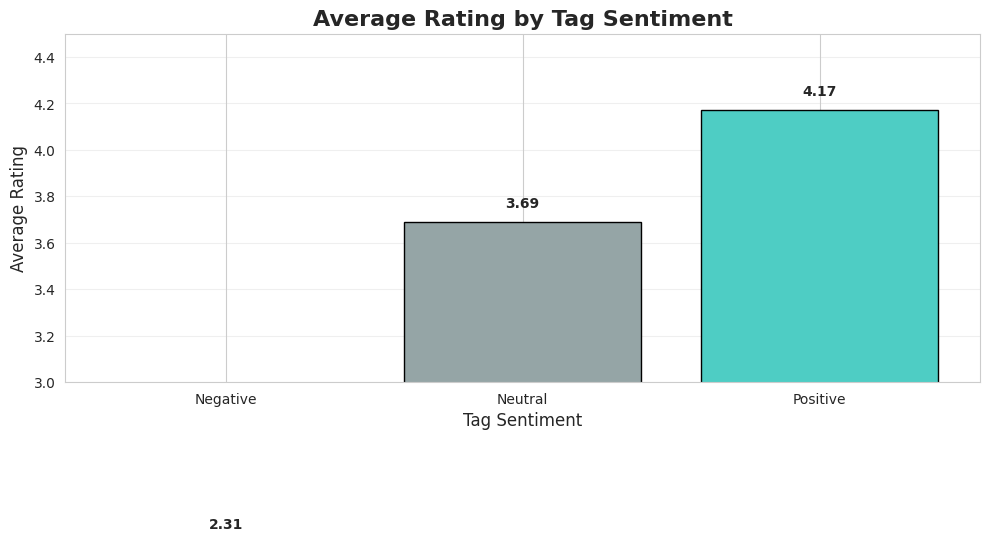

In [96]:
# Create sentiment keywords
positive_keywords = ['great', 'excellent', 'amazing', 'love', 'favorite', 'masterpiece',
                     'brilliant', 'best', 'perfect', 'outstanding']
negative_keywords = ['bad', 'boring', 'terrible', 'worst', 'awful', 'poor', 'waste',
                     'disappointing', 'dull', 'horrible']

def classify_sentiment(tag):
    tag_lower = str(tag).lower()
    if any(word in tag_lower for word in positive_keywords):
        return 'Positive'
    elif any(word in tag_lower for word in negative_keywords):
        return 'Negative'
    else:
        return 'Neutral'

# Sample tags for memory efficiency
tags_sample = tags.sample(n=min(500000, len(tags)), random_state=42) if len(tags) > 500000 else tags
tags_with_ratings = tags_sample.merge(ratings[['userId', 'movieId', 'rating']],
                                       on=['userId', 'movieId'], how='inner')
tags_with_ratings['sentiment'] = tags_with_ratings['tag_clean'].apply(classify_sentiment)

# Calculate sentiment statistics
sentiment_stats = tags_with_ratings.groupby('sentiment')['rating'].agg(['mean', 'count']).round(2)
print("\nTag Sentiment vs Average Rating:")
print(sentiment_stats)

# Plot
plt.figure(figsize=SMALL_FIG)
sentiment_order = ['Negative', 'Neutral', 'Positive']
sentiment_colors = ['#ff6b6b', '#95a5a6', '#4ecdc4']
sentiment_means = [sentiment_stats.loc[s, 'mean'] if s in sentiment_stats.index else 0
                   for s in sentiment_order]

plt.bar(range(len(sentiment_order)), sentiment_means, color=sentiment_colors, edgecolor='black')
plt.xticks(range(len(sentiment_order)), sentiment_order)
plt.title('Average Rating by Tag Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Tag Sentiment', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.ylim(3.0, 4.5)
plt.grid(axis='y', alpha=0.3)
for i, val in enumerate(sentiment_means):
    if val > 0:
        plt.text(i, val + 0.05, f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

### 2.5: Visualisation 10 - Trendy Tag Clusters


Trendy Tag Cluster Performance:
              mean  count
trend                    
Underrated    4.33    122
Mind-Bending  4.18   4765
Emotional     4.07   2096
Dark/Intense  4.07   6127
Entertaining  3.84   6484
Boring/Slow   2.67   2375


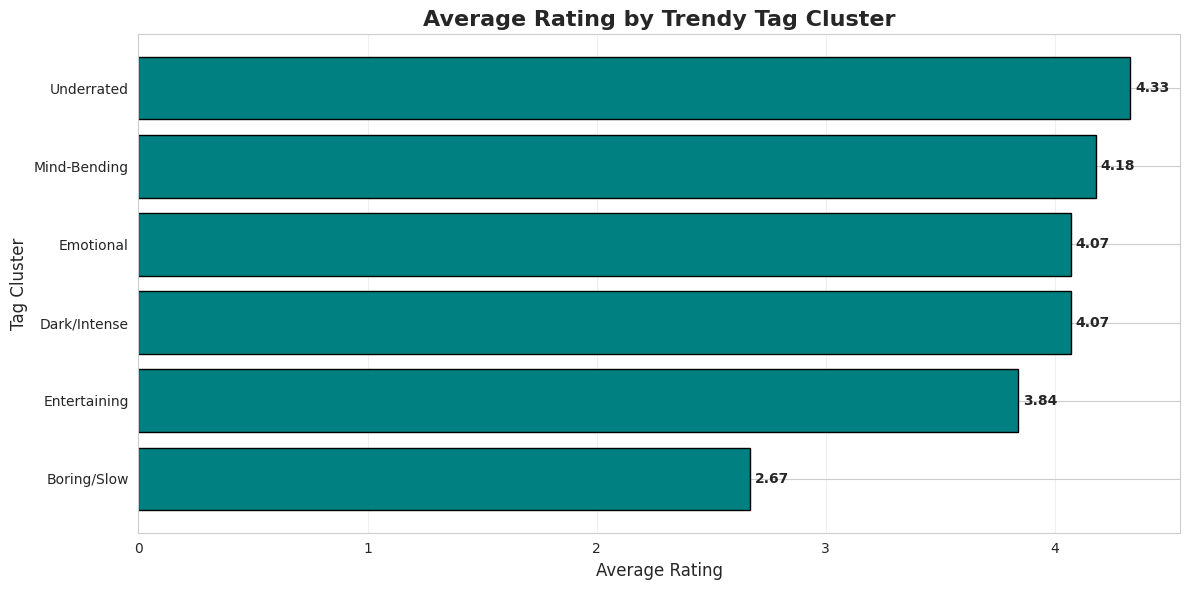

In [97]:
# Define trendy categories
trendy_categories = {
    'Underrated': ['underrated', 'hidden gem', 'overlooked', 'underappreciated'],
    'Mind-Bending': ['mind-bending', 'twist', 'psychological', 'complex'],
    'Emotional': ['emotional', 'touching', 'sad', 'heartwarming'],
    'Dark/Intense': ['dark', 'disturbing', 'violent', 'intense', 'brutal'],
    'Entertaining': ['fun', 'entertaining', 'funny', 'action'],
    'Boring/Slow': ['boring', 'slow', 'dull', 'overrated']
}

def classify_trend(tag):
    tag_lower = str(tag).lower()
    for category, keywords in trendy_categories.items():
        if any(keyword in tag_lower for keyword in keywords):
            return category
    return 'Other'

tags_with_ratings['trend'] = tags_with_ratings['tag_clean'].apply(classify_trend)

# Calculate trend statistics
trend_stats = tags_with_ratings[tags_with_ratings['trend'] != 'Other'].groupby('trend')['rating'].agg(['mean', 'count']).round(2)
trend_stats = trend_stats[trend_stats['count'] >= 100].sort_values('mean', ascending=False)

print("\nTrendy Tag Cluster Performance:")
print(trend_stats)

# Plot
if len(trend_stats) > 0:
    plt.figure(figsize=MEDIUM_FIG)
    plt.barh(range(len(trend_stats)), trend_stats['mean'].values, color='teal', edgecolor='black')
    plt.yticks(range(len(trend_stats)), trend_stats.index)
    plt.title('Average Rating by Trendy Tag Cluster', fontsize=16, fontweight='bold')
    plt.xlabel('Average Rating', fontsize=12)
    plt.ylabel('Tag Cluster', fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    for i, val in enumerate(trend_stats['mean'].values):
        plt.text(val + 0.02, i, f'{val:.2f}', ha='left', va='center', fontweight='bold')
    plt.tight_layout()
    plt.show()
    plt.close()

## SECTION 3: HIDDEN PATTERNS

### 3.1: Visualization 11 - Impact of Release Year on Ratings


Average Rating by Decade:
        mean  count
decade             
1920.0  3.45    149
1930.0  3.44    367
1940.0  3.45    535
1950.0  3.42    730
1960.0  3.40   1066
1970.0  3.33   1284
1980.0  3.13   2145
1990.0  3.16   3451
2000.0  3.19   5470
2010.0  3.20   6859
2020.0  3.08    468


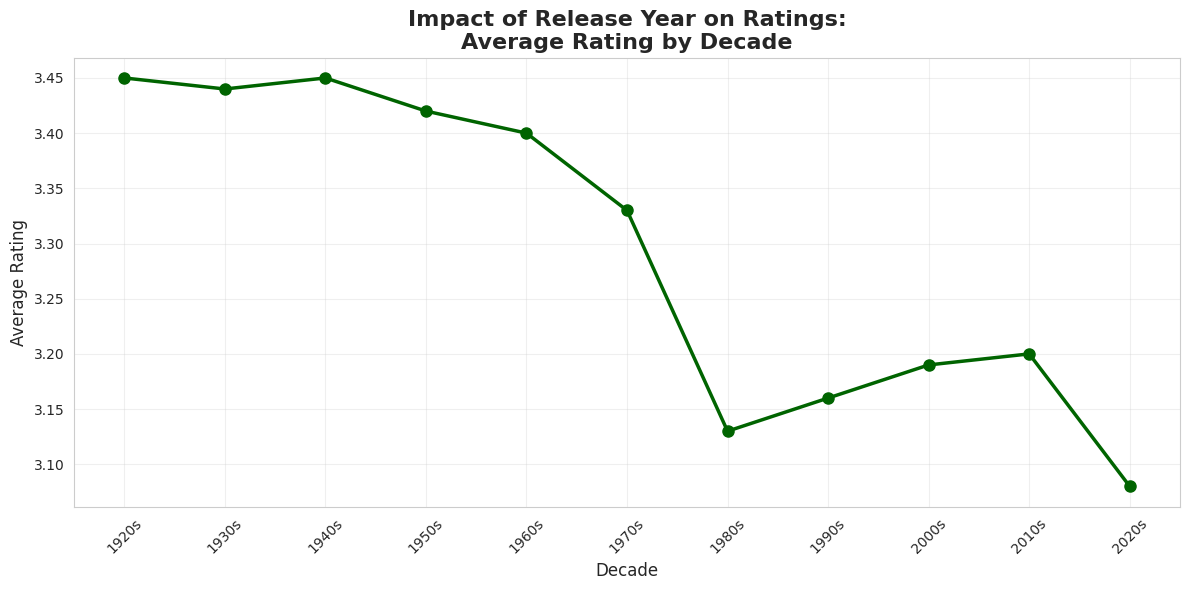

In [98]:
# Merge movie_stats with release year
movie_stats_full = movie_stats.reset_index().merge(
    movies[['movieId', 'title', 'release_year']], on='movieId', how='left'
)

# Filter valid years and sufficient ratings
movie_stats_full = movie_stats_full[
    (movie_stats_full['release_year'].notna()) &
    (movie_stats_full['release_year'] >= 1920) &
    (movie_stats_full['release_year'] <= 2020) &
    (movie_stats_full['num_ratings'] >= 20)
]

# Group by decade
movie_stats_full['decade'] = (movie_stats_full['release_year'] // 10) * 10
decade_stats = movie_stats_full.groupby('decade')['avg_rating'].agg(['mean', 'count']).round(2)

print("\nAverage Rating by Decade:")
print(decade_stats)

# Plot
plt.figure(figsize=MEDIUM_FIG)
plt.plot(decade_stats.index, decade_stats['mean'].values,
         marker='o', linewidth=2.5, markersize=8, color='darkgreen')
plt.title('Impact of Release Year on Ratings:\nAverage Rating by Decade',
          fontsize=16, fontweight='bold')
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(decade_stats.index, [f"{int(d)}s" for d in decade_stats.index], rotation=45)
plt.tight_layout()
plt.show()
plt.close()

### 3.2: Visualization 12 - Hidden Gems - High Ratings, Low Visibility


Found 81 hidden gems

Top 10 Hidden Gems:
                                                             title  release_year  num_ratings  avg_rating
                                           Twelve Angry Men (1954)        1954.0          332        4.31
                                   Century of the Self, The (2002)        2002.0          397        4.22
                                        Pride and Prejudice (1980)        1980.0           58        4.21
                                  It's Such a Beautiful Day (2011)        2011.0          328        4.19
                                               Human Planet (2011)        2011.0          498        4.18
                                            Isle of Flowers (1989)        1989.0           87        4.17
                             Can't Change the Meeting Place (1979)        1979.0          177        4.16
Ghost in the Shell: Stand Alone Complex - Individual Eleven (2006)        2006.0           50        4.16
   

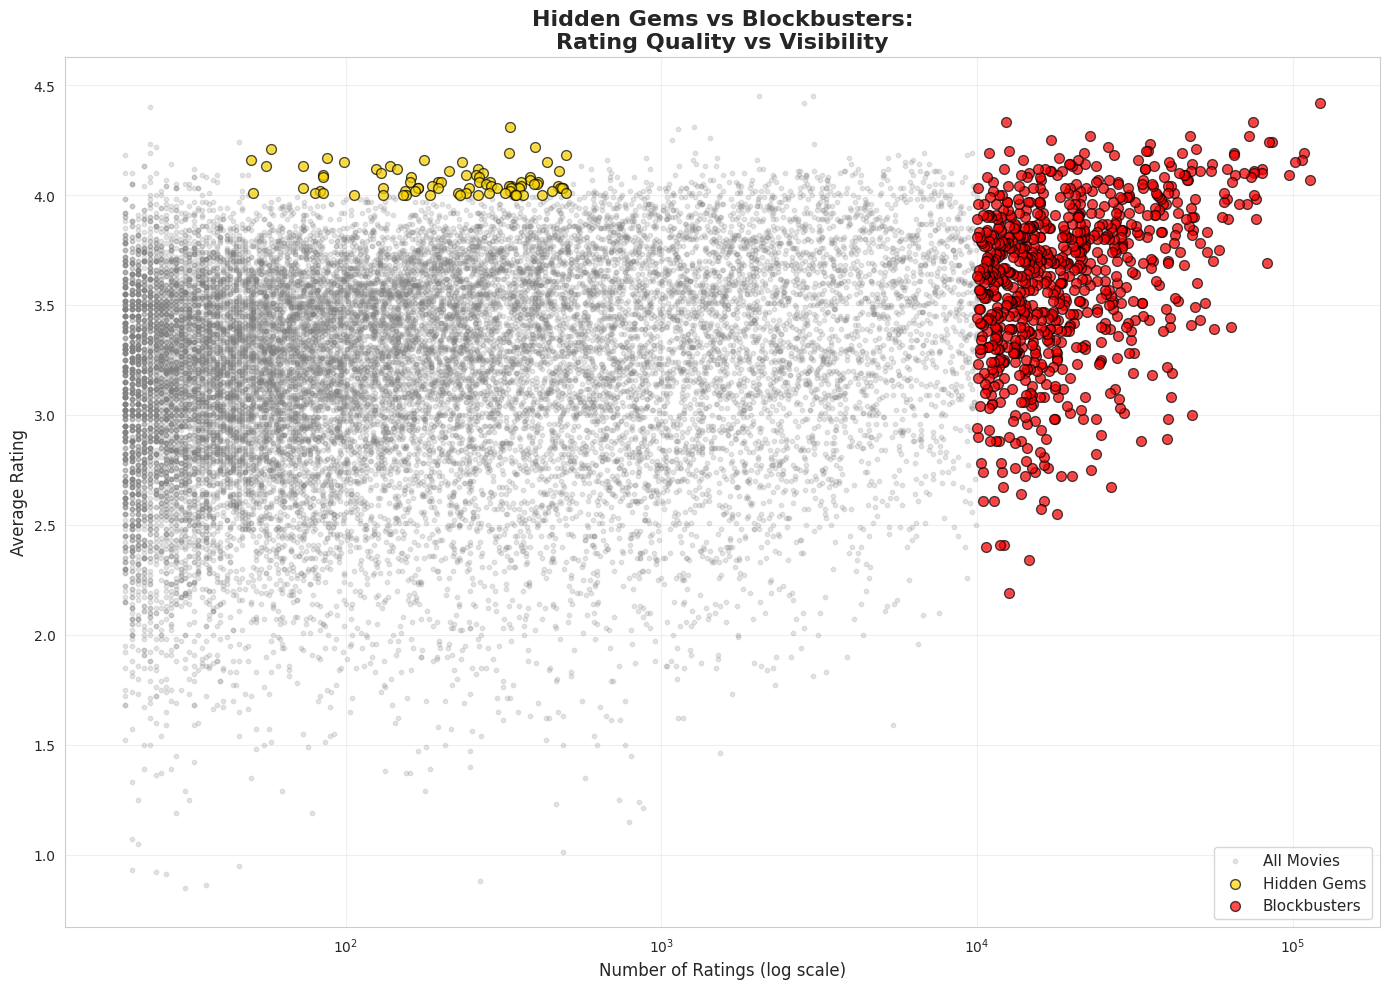

In [99]:
# Define hidden gems criteria
MIN_RATINGS = 50
MAX_RATINGS = 500
HIGH_RATING = 4.0

hidden_gems = movie_stats_full[
    (movie_stats_full['num_ratings'] >= MIN_RATINGS) &
    (movie_stats_full['num_ratings'] <= MAX_RATINGS) &
    (movie_stats_full['avg_rating'] >= HIGH_RATING)
].sort_values('avg_rating', ascending=False)

print(f"\nFound {len(hidden_gems)} hidden gems")
print("\nTop 10 Hidden Gems:")
print(hidden_gems.head(10)[['title', 'release_year', 'num_ratings', 'avg_rating']].to_string(index=False))

# Blockbusters for comparison
blockbusters = movie_stats_full[movie_stats_full['num_ratings'] >= 10000].sort_values('num_ratings', ascending=False)

# Plot scatter
plt.figure(figsize=LARGE_FIG)
plt.scatter(movie_stats_full['num_ratings'], movie_stats_full['avg_rating'],
           alpha=0.2, s=10, color='gray', label='All Movies')
plt.scatter(hidden_gems['num_ratings'], hidden_gems['avg_rating'],
           alpha=0.7, s=50, color='gold', edgecolors='black', label='Hidden Gems')
plt.scatter(blockbusters['num_ratings'], blockbusters['avg_rating'],
           alpha=0.7, s=50, color='red', edgecolors='black', label='Blockbusters')
plt.xscale('log')
plt.title('Hidden Gems vs Blockbusters:\nRating Quality vs Visibility',
          fontsize=16, fontweight='bold')
plt.xlabel('Number of Ratings (log scale)', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

### 3.3: Visualization 13 - Genre Affinity Clusters - User Taste Profiles


Performing user taste clustering
Created user-genre matrix: 2920 users x 19 genres

Cluster Distribution:
  Cluster 0: 237 users (8.1%)
  Cluster 1: 797 users (27.3%)
  Cluster 2: 165 users (5.7%)
  Cluster 3: 1149 users (39.3%)
  Cluster 4: 572 users (19.6%)

Top Genres per Cluster:

Cluster 0 (Top 3 genres):
  Drama: 3.95
  Crime: 3.91
  Thriller: 3.80

Cluster 1 (Top 3 genres):
  Drama: 3.26
  War: 3.24
  Crime: 3.22

Cluster 2 (Top 3 genres):
  Drama: 2.91
  Crime: 2.53
  Comedy: 2.51

Cluster 3 (Top 3 genres):
  War: 3.81
  Drama: 3.73
  Crime: 3.70

Cluster 4 (Top 3 genres):
  War: 4.24
  Crime: 4.22
  Drama: 4.22


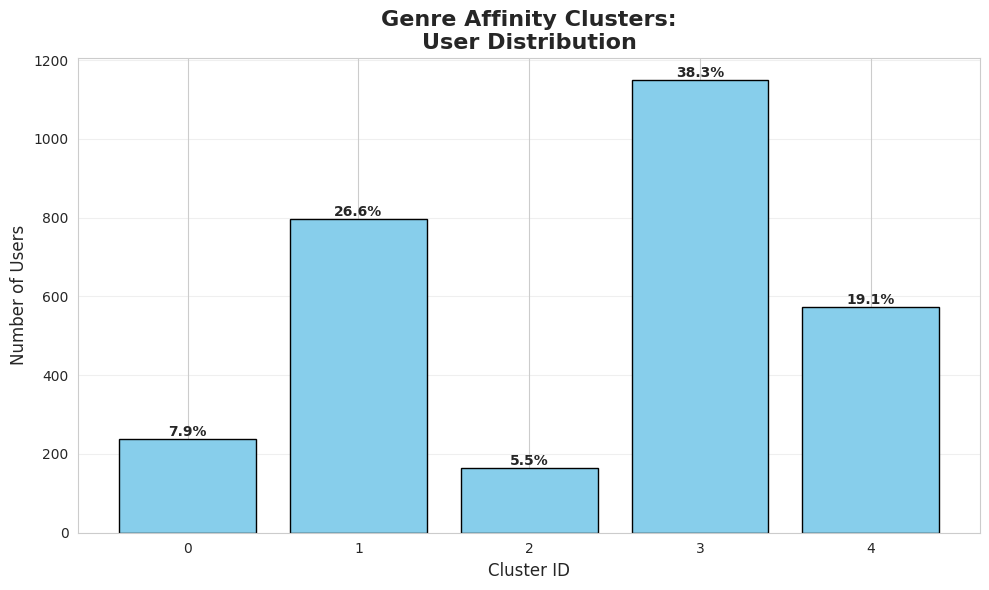

In [100]:
print("\nPerforming user taste clustering")

# Sample users for memory efficiency
SAMPLE_USERS = 3000  # Reduced from 5000 for memory
user_sample_ids = ratings['userId'].sample(n=SAMPLE_USERS, replace=False, random_state=42).unique()
ratings_sample_cluster = ratings[ratings['userId'].isin(user_sample_ids)].copy()

# Create user-genre matrix
ratings_with_genres = ratings_sample_cluster.merge(movies[['movieId', 'genre_list']], on='movieId')
ratings_exploded = ratings_with_genres.explode('genre_list')
ratings_exploded = ratings_exploded[
    (ratings_exploded['genre_list'].notna()) &
    (ratings_exploded['genre_list'] != '') &
    (ratings_exploded['genre_list'] != '(no genres listed)')
]

# Calculate average rating per user per genre
user_genre_matrix = ratings_exploded.groupby(['userId', 'genre_list'])['rating'].mean().unstack(fill_value=0)
print(f"Created user-genre matrix: {user_genre_matrix.shape[0]} users x {user_genre_matrix.shape[1]} genres")

# Standardize and cluster
scaler = StandardScaler()
user_genre_scaled = scaler.fit_transform(user_genre_matrix)

N_CLUSTERS = 5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans.fit_predict(user_genre_scaled)
user_genre_matrix['cluster'] = clusters

print(f"\nCluster Distribution:")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = count / len(clusters) * 100
    print(f"  Cluster {cluster_id}: {count} users ({pct:.1f}%)")

# Analyze cluster characteristics
print("\nTop Genres per Cluster:")
for cluster_id in range(N_CLUSTERS):
    cluster_users = user_genre_matrix[user_genre_matrix['cluster'] == cluster_id]
    avg_ratings = cluster_users.drop('cluster', axis=1).mean().sort_values(ascending=False)
    print(f"\nCluster {cluster_id} (Top 3 genres):")
    for genre, rating in avg_ratings.head(3).items():
        print(f"  {genre}: {rating:.2f}")

# Plot cluster distribution
plt.figure(figsize=SMALL_FIG)
plt.bar(range(N_CLUSTERS), [cluster_counts.get(i, 0) for i in range(N_CLUSTERS)],
        color='skyblue', edgecolor='black')
plt.title('Genre Affinity Clusters:\nUser Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(range(N_CLUSTERS))
plt.grid(axis='y', alpha=0.3)
for i, count in enumerate([cluster_counts.get(i, 0) for i in range(N_CLUSTERS)]):
    pct = count / SAMPLE_USERS * 100
    plt.text(i, count, f"{pct:.1f}%", ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

### 3.3: Visualization 14 - Cluster Profile Heatmap


Visualization 14: Cluster Profile Heatmap


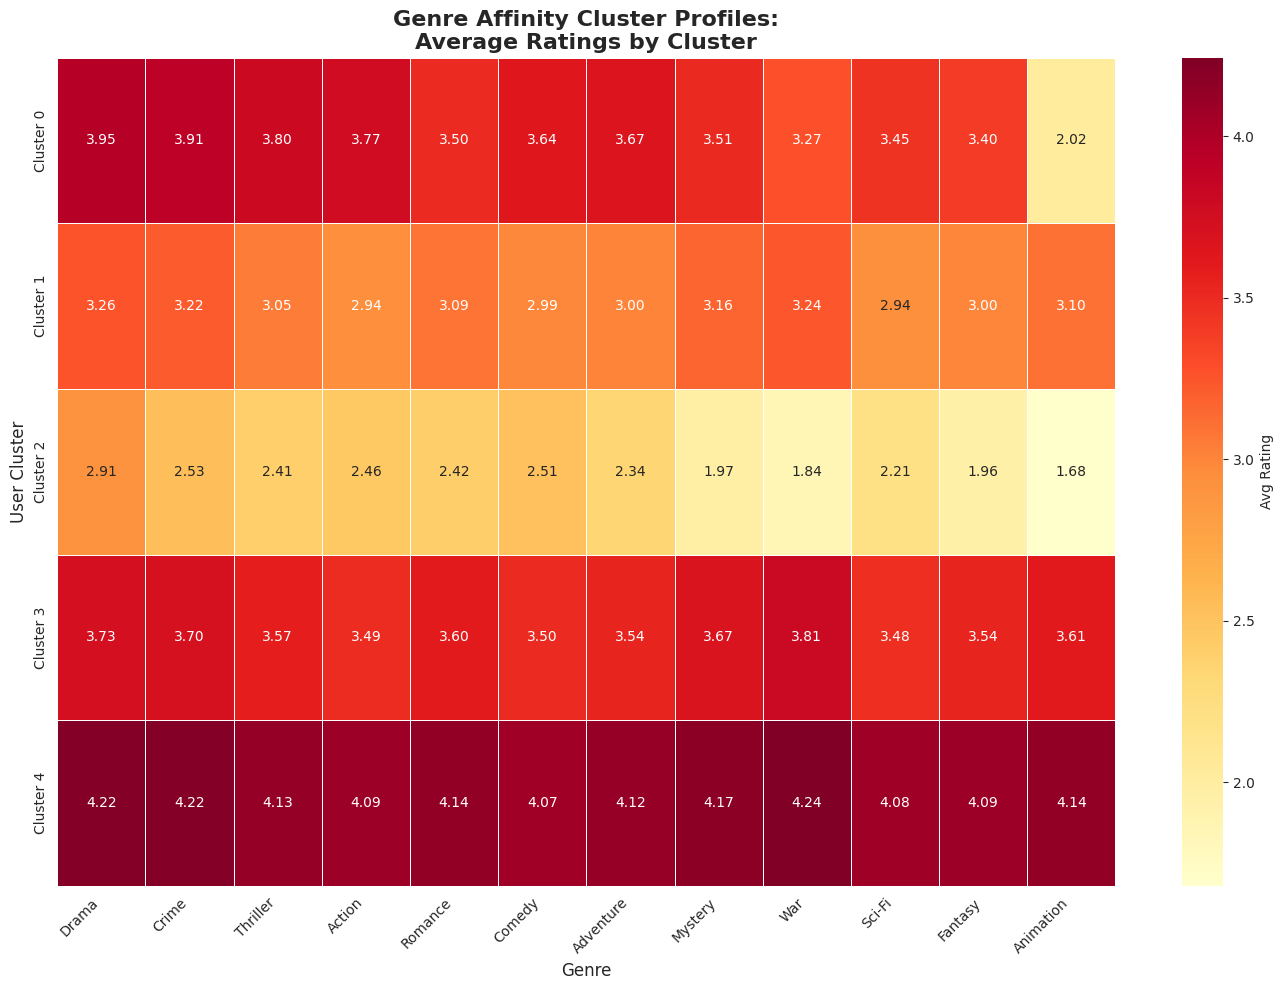

In [101]:
# Heatmap of cluster profiles
print("\nVisualization 14: Cluster Profile Heatmap")
cluster_profiles = []
for cluster_id in range(N_CLUSTERS):
    cluster_users = user_genre_matrix[user_genre_matrix['cluster'] == cluster_id]
    cluster_mean = cluster_users.drop('cluster', axis=1).mean()
    cluster_profiles.append(cluster_mean)

cluster_heatmap = pd.DataFrame(cluster_profiles)
cluster_heatmap.index = [f'Cluster {i}' for i in range(N_CLUSTERS)]

# Select top genres for visualization
top_genres_for_viz = cluster_heatmap.mean().nlargest(12).index
cluster_heatmap_subset = cluster_heatmap[top_genres_for_viz]

plt.figure(figsize=LARGE_FIG)
sns.heatmap(cluster_heatmap_subset, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'Avg Rating'}, linewidths=0.5)
plt.title('Genre Affinity Cluster Profiles:\nAverage Ratings by Cluster',
          fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('User Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()

 C. Recommendation System

Non - Personalized Baseline (Weighted Popularity Score)

In [102]:
print("\nBuilding popularity-based recommendation system")

# Calculate movie statistics
movie_popularity = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean']
}).reset_index()
movie_popularity.columns = ['movieId', 'num_ratings', 'avg_rating']


Building popularity-based recommendation system


## IMDB Weighted Rating Formula: WR = (v/(v+m)) * R + (m/(v+m)) * C
## Where:
## R = average rating for the movie
## v = number of votes for the movie
## m = minimum votes required (we'll use 25th percentile)
## C = mean rating across all movies

In [103]:
C = movie_popularity['avg_rating'].mean()
m = movie_popularity['num_ratings'].quantile(0.25)

In [104]:
print(f"\nWeighted Rating Parameters:")
print(f"  Mean rating across all movies (C): {C:.2f}")
print(f"  Minimum votes required (m):        {m:.0f} ratings")


Weighted Rating Parameters:
  Mean rating across all movies (C): 3.01
  Minimum votes required (m):        2 ratings


In [105]:
# Calculate weighted rating
def weighted_rating(row, m=m, C=C):
    """Calculate IMDB-style weighted rating"""
    v = row['num_ratings']
    R = row['avg_rating']
    return (v/(v+m)) * R + (m/(v+m)) * C

In [106]:
movie_popularity['weighted_score'] = movie_popularity.apply(weighted_rating, axis=1)

In [107]:
# Merge with movie titles
movie_popularity = movie_popularity.merge(
    movies[['movieId', 'title', 'genres', 'release_year']],
    on='movieId'
)

In [108]:
# Sort by weighted score
top_movies_weighted = movie_popularity.sort_values('weighted_score', ascending=False)

In [109]:
print("\nTop 20 Movies by Weighted Popularity Score")
print(top_movies_weighted.head(20)[['title', 'release_year', 'num_ratings', 'avg_rating', 'weighted_score']].to_string(index=False))


Top 20 Movies by Weighted Popularity Score
                                              title  release_year  num_ratings  avg_rating  weighted_score
                             Planet Earth II (2016)        2016.0         2041    4.451739        4.450331
                                Planet Earth (2006)        2006.0         3015    4.448093        4.447141
                            Band of Brothers (2001)        2001.0         2835    4.423986        4.422991
                   Shawshank Redemption, The (1994)        1994.0       122296    4.416792        4.416769
      BTS World Tour: Love Yourself in Seoul (2019)        2019.0            8    4.750000        4.402541
                 Money Heist: The Phenomenon (2020)        2020.0           10    4.650000        4.377118
                                             Cosmos           NaN          625    4.343200        4.338956
            The Matrix Revolutions Revisited (2004)        2004.0            4    5.000000        4.

In [110]:
# Create Top-N Global Recommendation Function
def get_top_n_global(n=10, min_votes=None):
    """
    Get Top-N movies globally based on weighted popularity score

    Args:
        n (int): Number of recommendations to return
        min_votes (int): Minimum number of votes required (default uses m from calculation)

    Returns:
        pd.DataFrame: Top N movies with scores
    """
    if min_votes is None:
        min_votes = m

    # Filter movies with minimum votes
    qualified_movies = movie_popularity[movie_popularity['num_ratings'] >= min_votes]

    # Sort by weighted score and return top N
    top_n = qualified_movies.sort_values('weighted_score', ascending=False).head(n)

    return top_n[['movieId', 'title', 'genres', 'release_year', 'num_ratings', 'avg_rating', 'weighted_score']]

In [111]:
# Test with different N values
print("\nTop 5 Global Recommendations:")
print(get_top_n_global(n=5).to_string(index=False))


Top 5 Global Recommendations:
 movieId                                         title           genres  release_year  num_ratings  avg_rating  weighted_score
  171011                        Planet Earth II (2016)      Documentary        2016.0         2041    4.451739        4.450331
  159817                           Planet Earth (2006)      Documentary        2006.0         3015    4.448093        4.447141
  170705                       Band of Brothers (2001) Action|Drama|War        2001.0         2835    4.423986        4.422991
     318              Shawshank Redemption, The (1994)      Crime|Drama        1994.0       122296    4.416792        4.416769
  199618 BTS World Tour: Love Yourself in Seoul (2019)      Documentary        2019.0            8    4.750000        4.402541


In [112]:
print("\nTop 10 Global Recommendations:")
print(get_top_n_global(n=10).to_string(index=False))


Top 10 Global Recommendations:
 movieId                                         title             genres  release_year  num_ratings  avg_rating  weighted_score
  171011                        Planet Earth II (2016)        Documentary        2016.0         2041    4.451739        4.450331
  159817                           Planet Earth (2006)        Documentary        2006.0         3015    4.448093        4.447141
  170705                       Band of Brothers (2001)   Action|Drama|War        2001.0         2835    4.423986        4.422991
     318              Shawshank Redemption, The (1994)        Crime|Drama        1994.0       122296    4.416792        4.416769
  199618 BTS World Tour: Love Yourself in Seoul (2019)        Documentary        2019.0            8    4.750000        4.402541
  247466            Money Heist: The Phenomenon (2020)        Documentary        2020.0           10    4.650000        4.377118
  171495                                        Cosmos (no genres

In [113]:
print("\nTop 30 Global Recommendations with a minimum of 100 votes:")
print(get_top_n_global(n=30, min_votes=100).to_string(index=False))


Top 30 Global Recommendations with a minimum of 100 votes:
 movieId                                                                       title                            genres  release_year  num_ratings  avg_rating  weighted_score
  171011                                                      Planet Earth II (2016)                       Documentary        2016.0         2041    4.451739        4.450331
  159817                                                         Planet Earth (2006)                       Documentary        2006.0         3015    4.448093        4.447141
  170705                                                     Band of Brothers (2001)                  Action|Drama|War        2001.0         2835    4.423986        4.422991
     318                                            Shawshank Redemption, The (1994)                       Crime|Drama        1994.0       122296    4.416792        4.416769
  171495                                                              

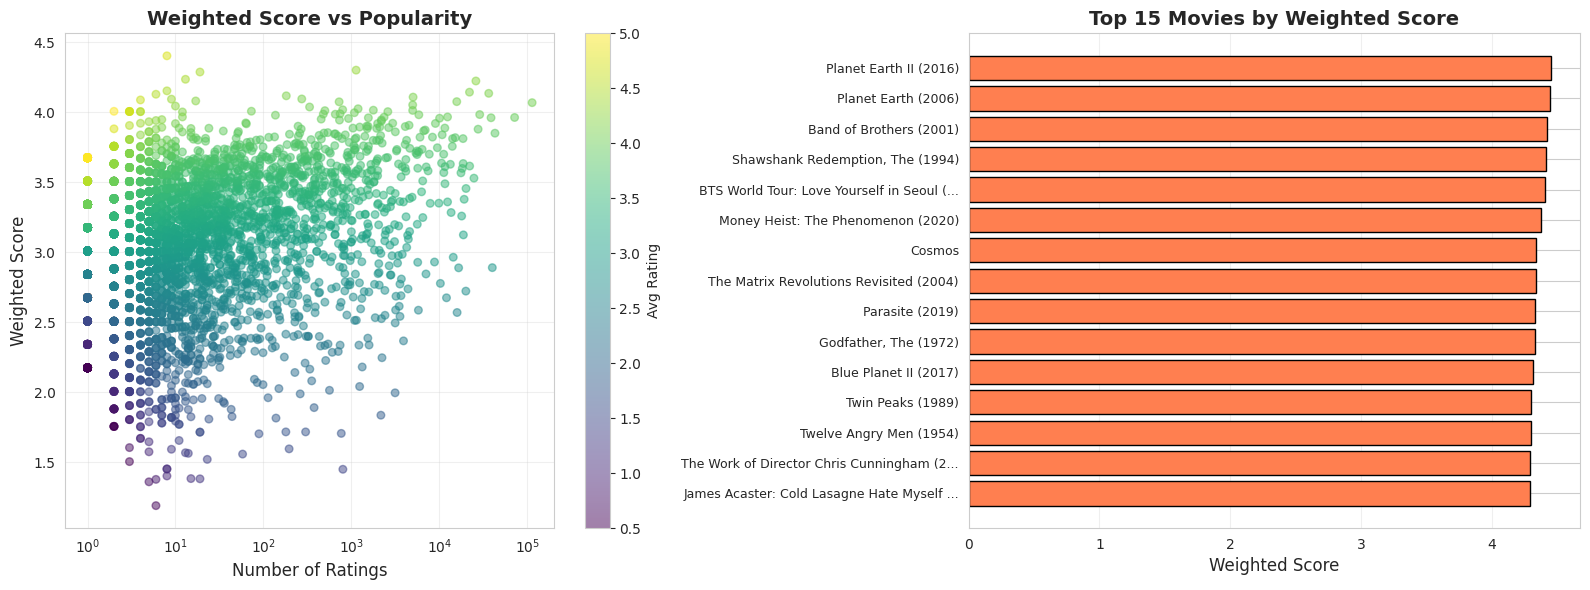

In [114]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Weighted Score vs Number of Ratings
ax = axes[0]
sample_movies = movie_popularity.sample(n=min(5000, len(movie_popularity)), random_state=42)
scatter = ax.scatter(sample_movies['num_ratings'],
                     sample_movies['weighted_score'],
                     c=sample_movies['avg_rating'],
                     cmap='viridis',
                     alpha=0.5,
                     s=30)
ax.set_xlabel('Number of Ratings', fontsize=12)
ax.set_ylabel('Weighted Score', fontsize=12)
ax.set_title('Weighted Score vs Popularity', fontsize=14, fontweight='bold')
ax.set_xscale('log')
plt.colorbar(scatter, ax=ax, label='Avg Rating')
ax.grid(alpha=0.3)

# Plot 2: Top 15 Movies
ax = axes[1]
top_15 = top_movies_weighted.head(15)
ax.barh(range(len(top_15)), top_15['weighted_score'], color='coral', edgecolor='black')
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels([title[:40] + '...' if len(title) > 40 else title for title in top_15['title']], fontsize=9)
ax.set_xlabel('Weighted Score', fontsize=12)
ax.set_title('Top 15 Movies by Weighted Score', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [115]:
print("\n[Baseline Performance Metrics]")
print(f"Total movies in catalog:        {len(movie_popularity):,}")
print(f"Movies with min votes (>{m}):   {(movie_popularity['num_ratings'] > m).sum():,}")
print(f"Average weighted score:         {movie_popularity['weighted_score'].mean():.3f}")
print(f"Top movie weighted score:       {movie_popularity['weighted_score'].max():.3f}")


[Baseline Performance Metrics]
Total movies in catalog:        83,239
Movies with min votes (>2.0):   55,162
Average weighted score:         3.043
Top movie weighted score:       4.450


Feature Engineering

In [116]:
print("\nUser Behavior Features")
user_features = ratings.groupby('userId').agg({
    'rating': ['count', 'mean', 'std']
}).round(4)
user_features.columns = ['user_rating_count', 'user_avg_rating', 'user_rating_std']
user_features['user_rating_std'] = user_features['user_rating_std'].fillna(0)
user_features = user_features.reset_index()
print(f" User features for {len(user_features):,} users")


User Behavior Features
 User features for 330,975 users


In [117]:
print("\n Movie Statistics Features")
movie_features_stats = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean', 'std']
}).round(4)
movie_features_stats.columns = ['movie_rating_count', 'movie_avg_rating', 'movie_rating_std']
movie_features_stats['movie_rating_std'] = movie_features_stats['movie_rating_std'].fillna(0)
movie_features_stats = movie_features_stats.reset_index()
print(f" Movie features for {len(movie_features_stats):,} movies")


 Movie Statistics Features
 Movie features for 83,239 movies


In [118]:
print("\nBuilding Enhanced Dataset")

# Sample ratings
SAMPLE_SIZE_ML = 10_000_000
print(f"Sampling {SAMPLE_SIZE_ML:,} ratings")
ratings_ml = ratings.sample(n=min(SAMPLE_SIZE_ML, len(ratings)), random_state=42)

# Merge all features
print("Merging features")
ml_data = ratings_ml.merge(movies[['movieId', 'genre_list', 'release_year']], on='movieId')
ml_data = ml_data.merge(user_features, on='userId', how='left')
ml_data = ml_data.merge(movie_features_stats, on='movieId', how='left')

# Add genome features
print("Adding genome features")
movie_genome_features = genome_scores.groupby('movieId')['relevance'].agg([
    'mean', 'std', 'min', 'max'
]).reset_index()
movie_genome_features.columns = ['movieId', 'genome_mean', 'genome_std', 'genome_min', 'genome_max']

ml_data = ml_data.merge(movie_genome_features, on='movieId', how='left')
ml_data = ml_data.fillna(0)
ml_data = ml_data[ml_data['release_year'] > 0]

print(f" Enhanced dataset: {len(ml_data):,} rows")


Building Enhanced Dataset
Sampling 10,000,000 ratings
Merging features
Adding genome features
 Enhanced dataset: 9,989,584 rows


In [119]:
# One-hot encode genres
print("\nEncoding Genres")
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(ml_data['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=ml_data.index)
print(f" Encoded {len(mlb.classes_)} genres")


Encoding Genres
 Encoded 19 genres


In [120]:
# Create feature matrix
print("\nCreating Feature Matrix")

numeric_cols = [
    'release_year',
    'genome_mean', 'genome_std', 'genome_min', 'genome_max',
    'user_rating_count', 'user_avg_rating', 'user_rating_std',
    'movie_rating_count', 'movie_avg_rating', 'movie_rating_std'
]

genre_df_reset = genre_df.reset_index(drop=True)
numeric_df_reset = ml_data[numeric_cols].reset_index(drop=True)

X = pd.concat([genre_df_reset, numeric_df_reset], axis=1)
y = ml_data['rating'].reset_index(drop=True).values

print(f"\nFeature Summary - Before Multicollinearity Check")
print(f"  Total samples:      {len(X):,}")
print(f"  Total features:     {X.shape[1]}")
print(f"  - Genre features:   {len(mlb.classes_)}")
print(f"  - Numeric features: {len(numeric_cols)}")


Creating Feature Matrix

Feature Summary - Before Multicollinearity Check
  Total samples:      9,989,584
  Total features:     30
  - Genre features:   19
  - Numeric features: 11


Multicollinearity Check


Multicollinearity Analysis

Found 1 highly correlated feature pairs (> 0.95):
  genome_std <-> genome_mean: 0.9652


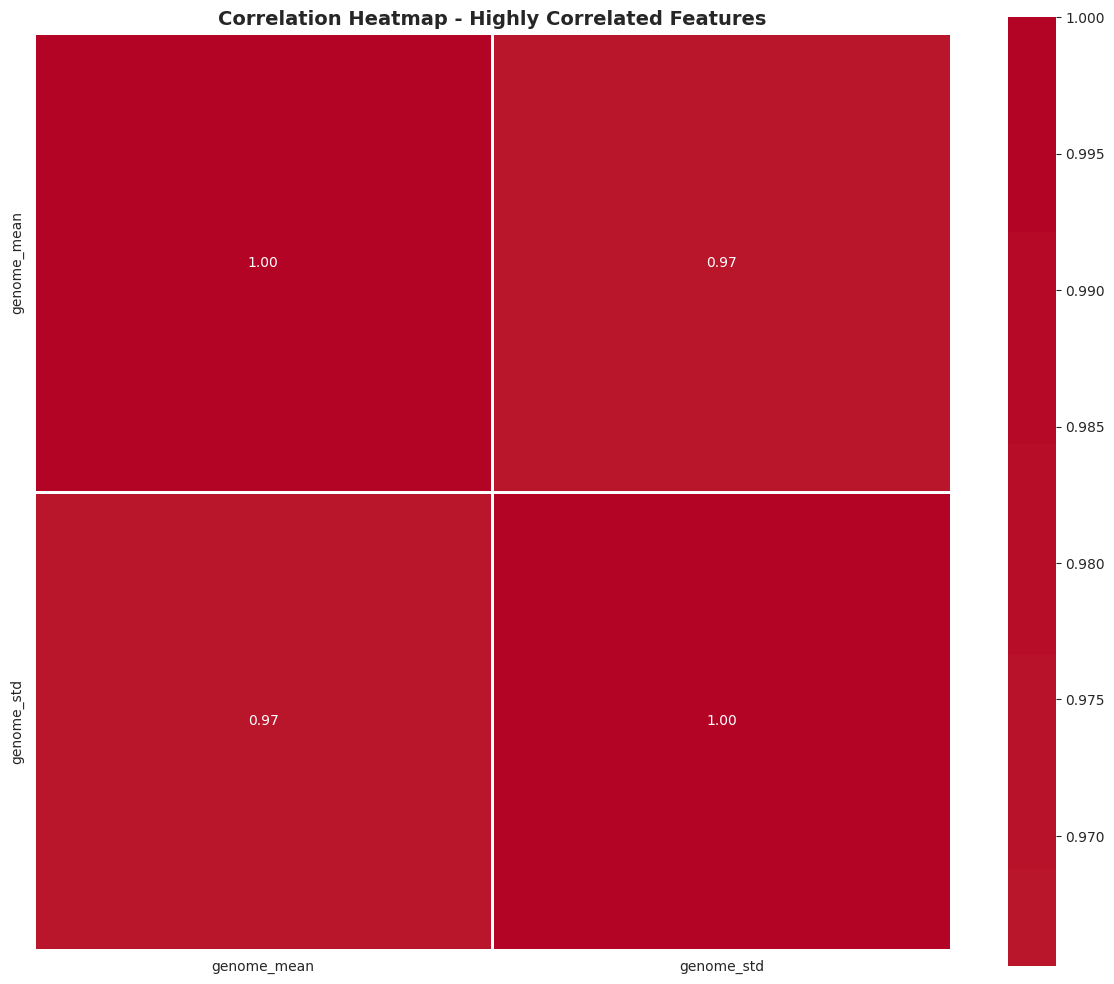


Removing 1 multicollinear features
  - genome_std
 Features after removal: 29

Final Feature Summary
  Total features:     29
  Features removed:   1


In [121]:
print("\nMulticollinearity Analysis")

# Calculate correlation matrix
corr_matrix = X.corr().abs()

# Find highly correlated pairs (> 0.95)
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = []
for column in upper_triangle.columns:
    corr_features = upper_triangle[column][upper_triangle[column] > 0.95]
    for idx in corr_features.index:
        high_corr_pairs.append((column, idx, corr_features[idx]))

if len(high_corr_pairs) > 0:
    print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs (> 0.95):")
    for feat1, feat2, corr_val in high_corr_pairs[:10]:  # Show first 10
        print(f"  {feat1} <-> {feat2}: {corr_val:.4f}")

    # Visualize correlation heatmap for highly correlated features
    if len(high_corr_pairs) <= 20:
        correlated_features = list(set([p[0] for p in high_corr_pairs] + [p[1] for p in high_corr_pairs]))

        plt.figure(figsize=(12, 10))
        corr_subset = X[correlated_features].corr()
        sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm',
                    center=0, square=True, linewidths=1)
        plt.title('Correlation Heatmap - Highly Correlated Features',
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        plt.close()
else:
    print(" No highly correlated features found")

# Remove multicollinear features
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

if len(to_drop) > 0:
    print(f"\nRemoving {len(to_drop)} multicollinear features")
    for feat in to_drop:
        print(f"  - {feat}")
    X = X.drop(columns=to_drop)
    print(f" Features after removal: {X.shape[1]}")

print(f"\nFinal Feature Summary")
print(f"  Total features:     {X.shape[1]}")
print(f"  Features removed:   {len(to_drop)}")

### Split Data Into Train/ Validation/ Test sets

In [122]:
print("\nSplitting data into train/validation/test sets")
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Splitting data into train/validation/test sets


In [123]:
# Second split: 75% train, 25% validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [124]:
print(f"  Training set:     {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation set:   {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test set:         {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

  Training set:     5,993,750 samples (60.0%)
  Validation set:   1,997,917 samples (20.0%)
  Test set:         1,997,917 samples (20.0%)


In [125]:
# Standardize features
print("\nStandardizing features")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Standardizing features


In [126]:
# Binary target for logistic regression
y_train_binary = (y_train >= 3.5).astype(int)
y_val_binary = (y_val >= 3.5).astype(int)
y_test_binary = (y_test >= 3.5).astype(int)

Train all Models

In [127]:
# RMSE scorer for tuning
rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

In [256]:
# Store all results
all_results = []

### Model 1: K-Nearest Neighbours (KNN)

In [129]:
# Subsample training data for KNN (using 200k samples)
KNN_TRAIN_SAMPLE = 200_000
print(f"Training on {KNN_TRAIN_SAMPLE:,} samples (KNN is slow)")

Training on 200,000 samples (KNN is slow)


In [130]:
knn_indices = np.random.choice(len(X_train_scaled), size=KNN_TRAIN_SAMPLE, replace=False)
X_train_knn = X_train_scaled[knn_indices]
y_train_knn = y_train[knn_indices]

In [131]:
knn_model = KNeighborsRegressor(n_neighbors=20, n_jobs=-1)
knn_model.fit(X_train_knn, y_train_knn)

KNeighborsRegressor(n_jobs=-1, n_neighbors=20)

In [132]:
y_pred_knn_val = knn_model.predict(X_val_scaled)
y_pred_knn_test = knn_model.predict(X_test_scaled)

In [133]:
rmse_knn_val = np.sqrt(mean_squared_error(y_val, y_pred_knn_val))
mae_knn_val = mean_absolute_error(y_val, y_pred_knn_val)
rmse_knn_test = np.sqrt(mean_squared_error(y_test, y_pred_knn_test))
mae_knn_test = mean_absolute_error(y_test, y_pred_knn_test)

In [134]:
print(f"\nKNN Results")
print(f"  Val  - RMSE: {rmse_knn_val:.4f}, MAE: {mae_knn_val:.4f}")
print(f"  Test - RMSE: {rmse_knn_test:.4f}, MAE: {mae_knn_test:.4f}")


KNN Results
  Val  - RMSE: 0.8952, MAE: 0.6864
  Test - RMSE: 0.8945, MAE: 0.6859


In [257]:
all_results.append({
    'Model': 'KNN',
    'Type': 'Content-Based',
    'Val_RMSE': rmse_knn_val,
    'Val_MAE': mae_knn_val,
    'Test_RMSE': rmse_knn_test,
    'Test_MAE': mae_knn_test
})

### Model 2: Random Forest

In [136]:
rf_param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [137]:
RF_TUNE_SAMPLE = 1_500_000
print(f"Tuning on {RF_TUNE_SAMPLE:,} samples")

Tuning on 1,500,000 samples


In [138]:
rf_tune_idx = np.random.choice(len(X_train), size=min(RF_TUNE_SAMPLE, len(X_train)), replace=False)

In [139]:
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    n_iter=20,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [140]:
print("Starting Random Forest tuning")
rf_search.fit(X_train.iloc[rf_tune_idx], y_train[rf_tune_idx])

Starting Random Forest tuning
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [10, 15, 20, 25, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 150, 200, 250]},
                   random_state=42,
                   scoring=make_scorer(<lambda>, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [141]:
print("\nBest Parameters")
for k, v in rf_search.best_params_.items():
    print(f"  {k}: {v}")


Best Parameters
  n_estimators: 100
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: log2
  max_depth: 10


In [142]:
print("\nTraining on full dataset")
rf_model = RandomForestRegressor(**rf_search.best_params_, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)


Training on full dataset


RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=2,
                      min_samples_split=10, n_jobs=-1, random_state=42)

In [143]:
y_pred_rf_val = rf_model.predict(X_val)
y_pred_rf_test = rf_model.predict(X_test)

In [144]:
rmse_rf_val = np.sqrt(mean_squared_error(y_val, y_pred_rf_val))
mae_rf_val = mean_absolute_error(y_val, y_pred_rf_val)
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)

In [145]:
print(f"\nRandom Forest Results")
print(f"  Val  - RMSE: {rmse_rf_val:.4f}, MAE: {mae_rf_val:.4f}")
print(f"  Test - RMSE: {rmse_rf_test:.4f}, MAE: {mae_rf_test:.4f}")


Random Forest Results
  Val  - RMSE: 0.8840, MAE: 0.6809
  Test - RMSE: 0.8828, MAE: 0.6800


In [258]:
all_results.append({
    'Model': 'Random Forest',
    'Type': 'Content-Based',
    'Val_RMSE': rmse_rf_val,
    'Val_MAE': mae_rf_val,
    'Test_RMSE': rmse_rf_test,
    'Test_MAE': mae_rf_test
})

### Model 3: Ridge Regression

In [147]:
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0]
}

In [148]:
ridge_search = GridSearchCV(
    Ridge(),
    ridge_param_grid,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1
)

In [149]:
print("Starting Ridge tuning")
ridge_search.fit(X_train_scaled, y_train)

Starting Ridge tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0,
                                   100.0, 500.0]},
             scoring=make_scorer(<lambda>, greater_is_better=False, response_method='predict'),
             verbose=1)

In [150]:
print(f"\nBest Parameters")
print(f"  alpha: {ridge_search.best_params_['alpha']}")


Best Parameters
  alpha: 500.0


In [151]:
ridge_model = ridge_search.best_estimator_

In [152]:
y_pred_ridge_val = ridge_model.predict(X_val_scaled)
y_pred_ridge_test = ridge_model.predict(X_test_scaled)

In [153]:
rmse_ridge_val = np.sqrt(mean_squared_error(y_val, y_pred_ridge_val))
mae_ridge_val = mean_absolute_error(y_val, y_pred_ridge_val)
rmse_ridge_test = np.sqrt(mean_squared_error(y_test, y_pred_ridge_test))
mae_ridge_test = mean_absolute_error(y_test, y_pred_ridge_test)

In [154]:
print(f"\nRidge Results")
print(f"  Val  - RMSE: {rmse_ridge_val:.4f}, MAE: {mae_ridge_val:.4f}")
print(f"  Test - RMSE: {rmse_ridge_test:.4f}, MAE: {mae_ridge_test:.4f}")


Ridge Results
  Val  - RMSE: 0.8648, MAE: 0.6595
  Test - RMSE: 0.8635, MAE: 0.6587


In [259]:
all_results.append({
    'Model': 'Ridge',
    'Type': 'Content-Based',
    'Val_RMSE': rmse_ridge_val,
    'Val_MAE': mae_ridge_val,
    'Test_RMSE': rmse_ridge_test,
    'Test_MAE': mae_ridge_test
})

### Model 4: Logistic Regression

In [156]:
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

In [157]:
lr_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    lr_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [158]:
print("Starting Logistic Regression tuning")
lr_search.fit(X_train_scaled, y_train_binary)

Starting Logistic Regression tuning
Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'penalty': ['l2'], 'solver': ['lbfgs', 'saga']},
             scoring='accuracy', verbose=1)

In [159]:
print(f"\nBest Parameters")
for k, v in lr_search.best_params_.items():
    print(f"  {k}: {v}")


Best Parameters
  C: 0.01
  penalty: l2
  solver: lbfgs


In [160]:
lr_model = lr_search.best_estimator_

In [161]:
y_pred_lr_val = lr_model.predict(X_val_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

In [162]:
accuracy_lr_val = accuracy_score(y_val_binary, y_pred_lr_val)
accuracy_lr_test = accuracy_score(y_test_binary, y_pred_lr_test)

In [163]:
print(f"\nLogistic Regression Results")
print(f"  Val  - Accuracy: {accuracy_lr_val:.4f}")
print(f"  Test - Accuracy: {accuracy_lr_test:.4f}")


Logistic Regression Results
  Val  - Accuracy: 0.7434
  Test - Accuracy: 0.7440


In [260]:
all_results.append({
    'Model': 'Logistic Regression',
    'Type': 'Content-Based (Binary)',
    'Val_RMSE': np.nan,
    'Val_MAE': np.nan,
    'Test_RMSE': np.nan,
    'Test_MAE': np.nan,
    'Val_Accuracy': accuracy_lr_val,
    'Test_Accuracy': accuracy_lr_test
})

### Model 5: AdaBoost

In [165]:
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

In [166]:
ADA_TUNE_SAMPLE = 500_000
print(f"Tuning on {ADA_TUNE_SAMPLE:,} samples")

Tuning on 500,000 samples


In [167]:
ada_tune_idx = np.random.choice(len(X_train), size=min(ADA_TUNE_SAMPLE, len(X_train)), replace=False)

In [168]:
ada_search = RandomizedSearchCV(
    AdaBoostRegressor(random_state=42),
    ada_param_grid,
    n_iter=10,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [169]:
print("Starting AdaBoost tuning")
ada_search.fit(X_train.iloc[ada_tune_idx], y_train[ada_tune_idx])

Starting AdaBoost tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=AdaBoostRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42,
                   scoring=make_scorer(<lambda>, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [170]:
print("\nBest Parameters")
for k, v in ada_search.best_params_.items():
    print(f"  {k}: {v}")


Best Parameters
  n_estimators: 50
  loss: square
  learning_rate: 1.0


In [171]:
print("Training on full dataset")
ada_model = AdaBoostRegressor(**ada_search.best_params_, random_state=42)
ada_model.fit(X_train, y_train)

Training on full dataset


AdaBoostRegressor(loss='square', random_state=42)

In [172]:
y_pred_ada_val = ada_model.predict(X_val)
y_pred_ada_test = ada_model.predict(X_test)

In [173]:
rmse_ada_val = np.sqrt(mean_squared_error(y_val, y_pred_ada_val))
mae_ada_val = mean_absolute_error(y_val, y_pred_ada_val)
rmse_ada_test = np.sqrt(mean_squared_error(y_test, y_pred_ada_test))
mae_ada_test = mean_absolute_error(y_test, y_pred_ada_test)

In [174]:
print(f"\nAdaBoost Results")
print(f"  Val  - RMSE: {rmse_ada_val:.4f}, MAE: {mae_ada_val:.4f}")
print(f"  Test - RMSE: {rmse_ada_test:.4f}, MAE: {mae_ada_test:.4f}")


AdaBoost Results
  Val  - RMSE: 1.2106, MAE: 1.0125
  Test - RMSE: 1.2102, MAE: 1.0126


In [261]:
all_results.append({
    'Model': 'AdaBoost',
    'Type': 'Boosting',
    'Val_RMSE': rmse_ada_val,
    'Val_MAE': mae_ada_val,
    'Test_RMSE': rmse_ada_test,
    'Test_MAE': mae_ada_test
})

Model 6: XGBoost

In [176]:
xgb_param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [177]:
XGB_TUNE_SAMPLE = 1_000_000
print(f"Tuning on {XGB_TUNE_SAMPLE:,} samples")

Tuning on 1,000,000 samples


In [178]:
xgb_tune_idx = np.random.choice(len(X_train), size=min(XGB_TUNE_SAMPLE, len(X_train)), replace=False)

In [179]:
xgb_search = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    xgb_param_grid,
    n_iter=20,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [180]:
print("Starting XGBoost tuning")
xgb_search.fit(X_train.iloc[xgb_tune_idx], y_train[xgb_tune_idx])

Starting XGBoost tuning
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 7, 9],
                                        'n_estimators': [200, 300, 400],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42,
                   scoring=make_scorer(<lambda>, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [181]:
print("\n[Best Parameters]")
for k, v in xgb_search.best_params_.items():
    print(f"  {k}: {v}")


[Best Parameters]
  subsample: 0.9
  n_estimators: 200
  max_depth: 5
  learning_rate: 0.01
  colsample_bytree: 0.9


In [182]:
print("Training on full dataset")
xgb_model = XGBRegressor(**xgb_search.best_params_, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

Training on full dataset


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [183]:
y_pred_xgb_val = xgb_model.predict(X_val)
y_pred_xgb_test = xgb_model.predict(X_test)

In [184]:
rmse_xgb_val = np.sqrt(mean_squared_error(y_val, y_pred_xgb_val))
mae_xgb_val = mean_absolute_error(y_val, y_pred_xgb_val)
rmse_xgb_test = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb_test)

In [185]:
print(f"\nXGBoost Results")
print(f"  Val  - RMSE: {rmse_xgb_val:.4f}, MAE: {mae_xgb_val:.4f}")
print(f"  Test - RMSE: {rmse_xgb_test:.4f}, MAE: {mae_xgb_test:.4f}")


XGBoost Results
  Val  - RMSE: 0.8683, MAE: 0.6658
  Test - RMSE: 0.8671, MAE: 0.6650


In [262]:
all_results.append({
    'Model': 'XGBoost',
    'Type': 'Boosting',
    'Val_RMSE': rmse_xgb_val,
    'Val_MAE': mae_xgb_val,
    'Test_RMSE': rmse_xgb_test,
    'Test_MAE': mae_xgb_test
})

Model 7: CatBoost

In [187]:
cat_param_grid = {
    'iterations': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5]
}

In [188]:
CAT_TUNE_SAMPLE = 1_000_000
print(f"Tuning on {CAT_TUNE_SAMPLE:,} samples")

Tuning on 1,000,000 samples


In [189]:
cat_tune_idx = np.random.choice(len(X_train), size=min(CAT_TUNE_SAMPLE, len(X_train)), replace=False)

In [190]:
cat_search = RandomizedSearchCV(
    CatBoostRegressor(random_state=42, verbose=0),
    cat_param_grid,
    n_iter=20,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [191]:
print("Starting CatBoost tuning")
cat_search.fit(X_train.iloc[cat_tune_idx], y_train[cat_tune_idx])

Starting CatBoost tuning
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x78d60dbc4530>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'depth': [6, 8, 10],
                                        'iterations': [200, 300, 400],
                                        'l2_leaf_reg': [1, 3, 5],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42,
                   scoring=make_scorer(<lambda>, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [192]:
print("\nBest Parameters")
for k, v in cat_search.best_params_.items():
    print(f"  {k}: {v}")


Best Parameters
  learning_rate: 0.01
  l2_leaf_reg: 1
  iterations: 200
  depth: 6


In [193]:
print("Training on full dataset")
cat_model = CatBoostRegressor(**cat_search.best_params_, random_state=42, verbose=0)
cat_model.fit(X_train, y_train)

Training on full dataset


In [194]:
y_pred_cat_val = cat_model.predict(X_val)
y_pred_cat_test = cat_model.predict(X_test)

In [195]:
rmse_cat_val = np.sqrt(mean_squared_error(y_val, y_pred_cat_val))
mae_cat_val = mean_absolute_error(y_val, y_pred_cat_val)
rmse_cat_test = np.sqrt(mean_squared_error(y_test, y_pred_cat_test))
mae_cat_test = mean_absolute_error(y_test, y_pred_cat_test)

In [196]:
print(f"\nCatBoost Results")
print(f"  Val  - RMSE: {rmse_cat_val:.4f}, MAE: {mae_cat_val:.4f}")
print(f"  Test - RMSE: {rmse_cat_test:.4f}, MAE: {mae_cat_test:.4f}")


CatBoost Results
  Val  - RMSE: 0.8718, MAE: 0.6690
  Test - RMSE: 0.8707, MAE: 0.6683


In [263]:
all_results.append({
    'Model': 'CatBoost',
    'Type': 'Boosting',
    'Val_RMSE': rmse_cat_val,
    'Val_MAE': mae_cat_val,
    'Test_RMSE': rmse_cat_test,
    'Test_MAE': mae_cat_test
})

### Model 8: Gradient Boosting

In [198]:
gb_param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'subsample': [0.8, 1.0]
}

In [199]:
GB_TUNE_SAMPLE = 1_000_000
print(f"Tuning on {GB_TUNE_SAMPLE:,} samples")

Tuning on 1,000,000 samples


In [200]:
gb_tune_idx = np.random.choice(len(X_train), size=min(GB_TUNE_SAMPLE, len(X_train)), replace=False)

In [201]:
gb_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    n_iter=10,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [202]:
print("Starting Gradient Boosting tuning")
gb_search.fit(X_train.iloc[gb_tune_idx], y_train[gb_tune_idx])

Starting Gradient Boosting tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [5, 7],
                                        'n_estimators': [200, 300],
                                        'subsample': [0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(<lambda>, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [203]:
print("\nBest Parameters")
for k, v in gb_search.best_params_.items():
    print(f"  {k}: {v}")


Best Parameters
  subsample: 1.0
  n_estimators: 200
  max_depth: 5
  learning_rate: 0.05


In [204]:
print("Training on full dataset")
gb_model = GradientBoostingRegressor(**gb_search.best_params_, random_state=42)
gb_model.fit(X_train, y_train)

Training on full dataset


GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=200,
                          random_state=42)

In [205]:
y_pred_gb_val = gb_model.predict(X_val)
y_pred_gb_test = gb_model.predict(X_test)

In [206]:
rmse_gb_val = np.sqrt(mean_squared_error(y_val, y_pred_gb_val))
mae_gb_val = mean_absolute_error(y_val, y_pred_gb_val)
rmse_gb_test = np.sqrt(mean_squared_error(y_test, y_pred_gb_test))
mae_gb_test = mean_absolute_error(y_test, y_pred_gb_test)

In [207]:
print(f"\nGradient Boosting Results")
print(f"  Val  - RMSE: {rmse_gb_val:.4f}, MAE: {mae_gb_val:.4f}")
print(f"  Test - RMSE: {rmse_gb_test:.4f}, MAE: {mae_gb_test:.4f}")


Gradient Boosting Results
  Val  - RMSE: 0.8561, MAE: 0.6495
  Test - RMSE: 0.8544, MAE: 0.6486


In [264]:
all_results.append({
    'Model': 'GradientBoost',
    'Type': 'Boosting',
    'Val_RMSE': rmse_gb_val,
    'Val_MAE': mae_gb_val,
    'Test_RMSE': rmse_gb_test,
    'Test_MAE': mae_gb_test
})

### Model Comparison

In [265]:
# Add baseline
all_results.insert(0, {
    'Model': 'Baseline (Popularity)',
    'Type': 'Non-Personalized',
    'Val_RMSE': np.nan,
    'Val_MAE': np.nan,
    'Test_RMSE': np.nan,
    'Test_MAE': np.nan
})

In [266]:
results_df = pd.DataFrame(all_results)

In [267]:
# Sort by Test RMSE (excluding NaN)
results_df_sorted = results_df[results_df['Test_RMSE'].notna()].sort_values('Test_RMSE')

In [268]:
print("\nAll Models Ranked by Test RMSE")
print(results_df_sorted[['Model', 'Type', 'Val_RMSE', 'Test_RMSE', 'Test_MAE']].to_string(index=False))


All Models Ranked by Test RMSE
        Model          Type  Val_RMSE  Test_RMSE  Test_MAE
GradientBoost      Boosting  0.856051   0.854409  0.648555
        Ridge Content-Based  0.864830   0.863464  0.658686
      XGBoost      Boosting  0.868331   0.867088  0.664951
     CatBoost      Boosting  0.871845   0.870667  0.668274
Random Forest Content-Based  0.883953   0.882821  0.680014
          KNN Content-Based  0.895183   0.894496  0.685870
     AdaBoost      Boosting  1.210559   1.210226  1.012637


Metric Visualization of Top 3 Models

In [270]:
# Get top 3 models
top_3 = results_df_sorted.head(3)

In [271]:
print("\nTop 3 Models")
for idx, row in top_3.iterrows():
    print(f"  {row['Model']}: RMSE = {row['Test_RMSE']:.4f}")


Top 3 Models
  GradientBoost: RMSE = 0.8544
  Ridge: RMSE = 0.8635
  XGBoost: RMSE = 0.8671


In [276]:
# Get predictions for top 3
print("\nGenerating predictions for visualizations")

# Model 1: Gradient Boosting
y_pred_gb_val_viz = gb_model.predict(X_val)
y_pred_gb_test_viz = gb_model.predict(X_test)

# Model 2: Ridge
y_pred_ridge_val_viz = ridge_model.predict(X_val_scaled)
y_pred_ridge_test_viz = ridge_model.predict(X_test_scaled)

# Model 3: XGBoost
y_pred_xgb_val_viz = xgb_model.predict(X_val)
y_pred_xgb_test_viz = xgb_model.predict(X_test)


Generating predictions for visualizations


In [277]:
# Store all predictions
top_3_predictions = {
    'GradientBoost': {
        'val': y_pred_gb_val_viz,
        'test': y_pred_gb_test_viz,
        'color': '#2ecc71'
    },
    'Ridge': {
        'val': y_pred_ridge_val_viz,
        'test': y_pred_ridge_test_viz,
        'color': '#e74c3c'
    },
    'XGBoost': {
        'val': y_pred_xgb_val_viz,
        'test': y_pred_xgb_test_viz,
        'color': '#3498db'
    }

}

Prediction vs Actual (Scatter Plot)


Creating Prediction vs Actual Scatter Plots


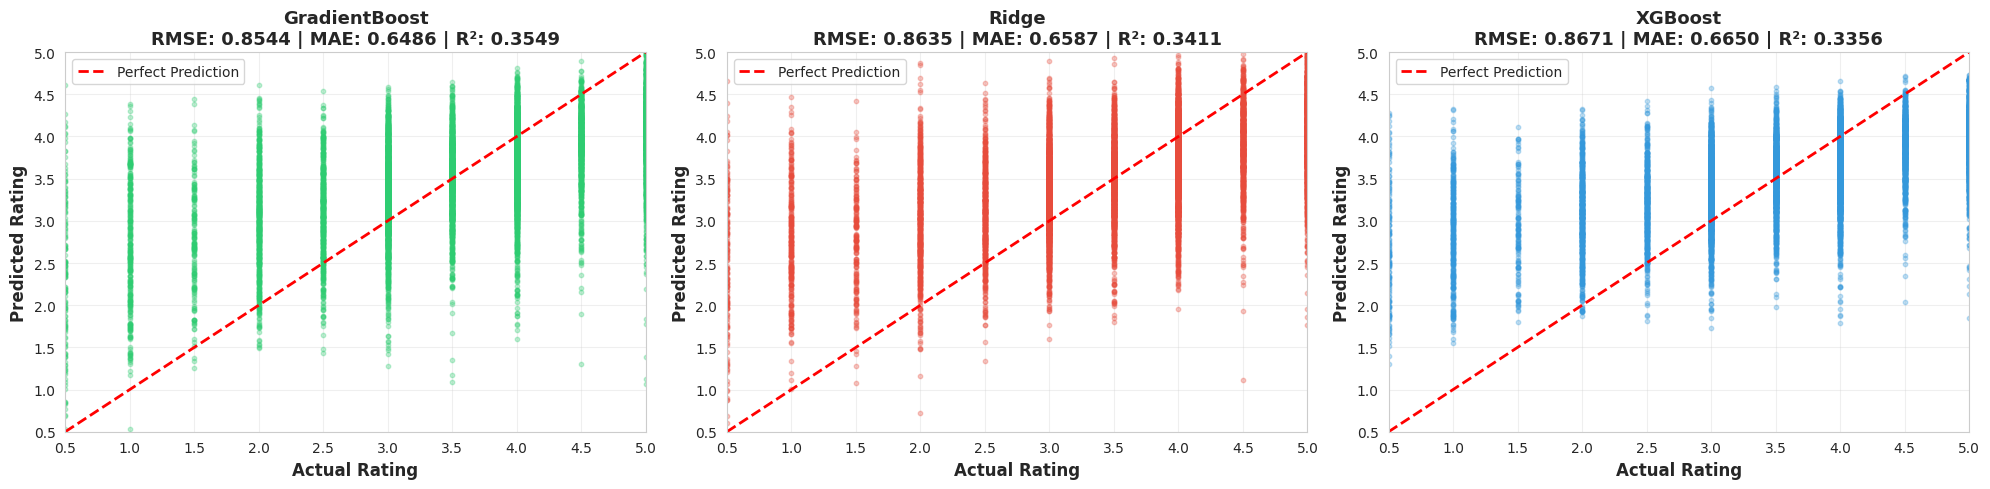

In [278]:
print("\nCreating Prediction vs Actual Scatter Plots")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, (model_name, preds) in enumerate(top_3_predictions.items()):
    ax = axes[idx]

    # Sample for visualization (too many points otherwise)
    sample_size = min(10000, len(y_test))
    sample_idx = np.random.choice(len(y_test), size=sample_size, replace=False)

    y_actual_sample = y_test[sample_idx]
    y_pred_sample = preds['test'][sample_idx]

    # Scatter plot
    ax.scatter(y_actual_sample, y_pred_sample, alpha=0.3, s=10, color=preds['color'])

    # Perfect prediction line
    ax.plot([0.5, 5], [0.5, 5], 'r--', lw=2, label='Perfect Prediction')

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds['test']))
    mae = mean_absolute_error(y_test, preds['test'])
    r2 = r2_score(y_test, preds['test'])

    ax.set_xlabel('Actual Rating', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Rating', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name}\nRMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}',
                 fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlim(0.5, 5)
    ax.set_ylim(0.5, 5)

plt.tight_layout()
plt.show()
plt.close()

Residul Plots


Creating Residual Plots


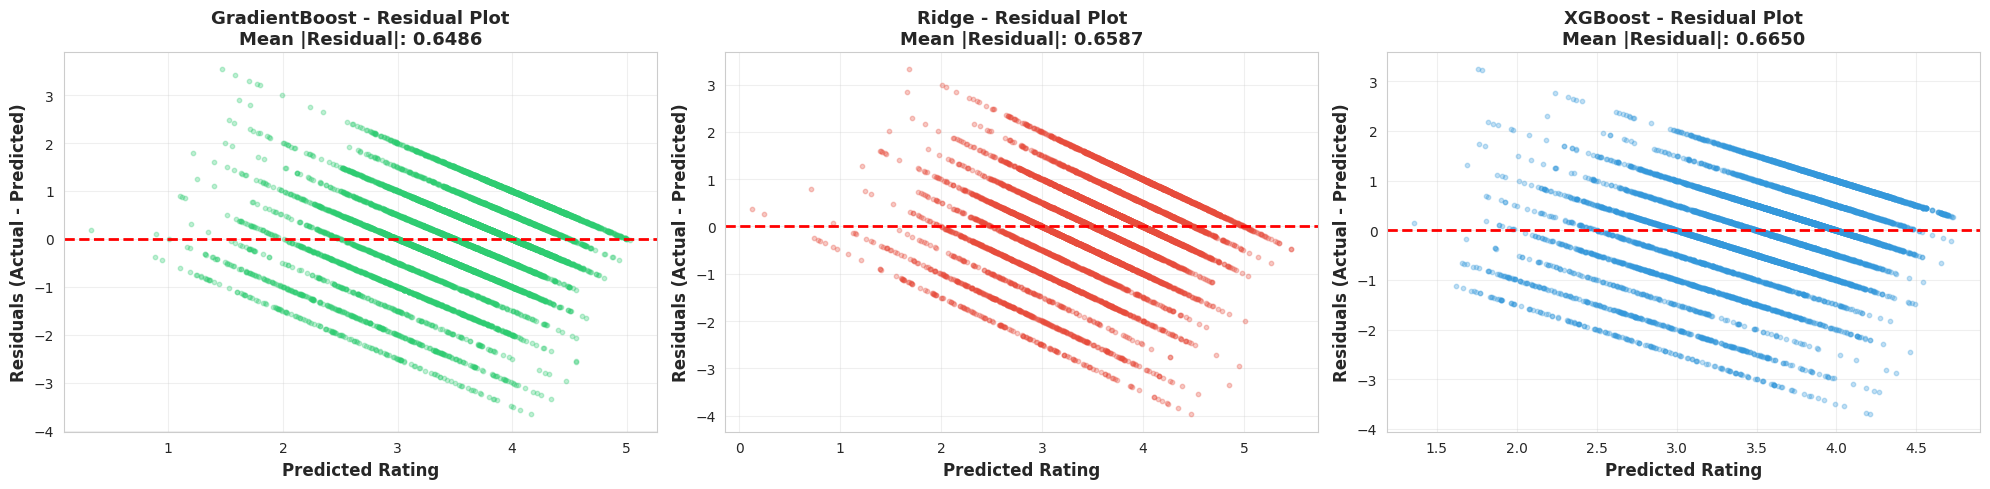

In [279]:
print("\nCreating Residual Plots")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, (model_name, preds) in enumerate(top_3_predictions.items()):
    ax = axes[idx]

    # Calculate residuals
    residuals = y_test - preds['test']

    # Sample for visualization
    sample_size = min(10000, len(residuals))
    sample_idx = np.random.choice(len(residuals), size=sample_size, replace=False)

    # Scatter plot
    ax.scatter(preds['test'][sample_idx], residuals[sample_idx],
               alpha=0.3, s=10, color=preds['color'])
    ax.axhline(y=0, color='r', linestyle='--', lw=2)

    # Mean absolute residual
    mean_residual = np.mean(np.abs(residuals))

    ax.set_xlabel('Predicted Rating', fontsize=12, fontweight='bold')
    ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name} - Residual Plot\nMean |Residual|: {mean_residual:.4f}',
                 fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

Error Distribution (Histogram)


Creating Error Distribution Plots


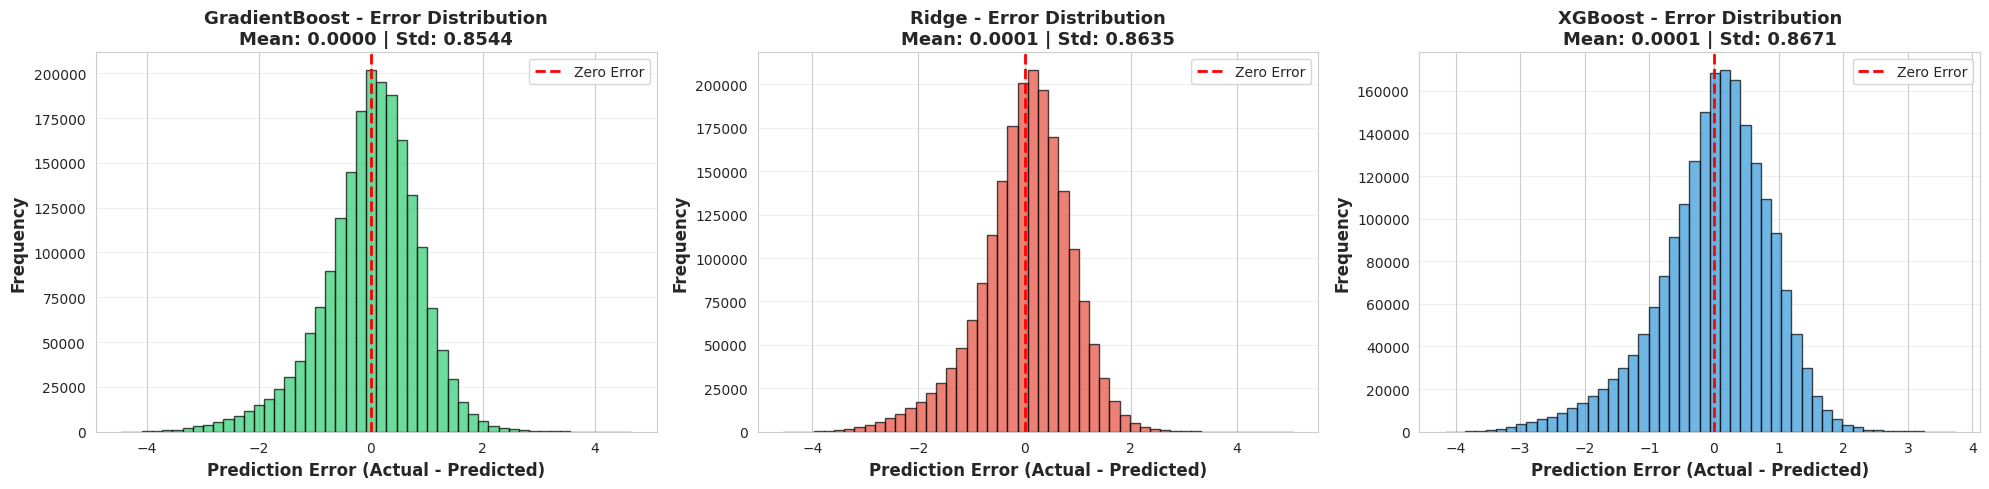

In [280]:
print("\nCreating Error Distribution Plots")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, (model_name, preds) in enumerate(top_3_predictions.items()):
    ax = axes[idx]

    # Calculate errors
    errors = y_test - preds['test']

    # Histogram
    ax.hist(errors, bins=50, alpha=0.7, color=preds['color'], edgecolor='black')

    # Add vertical line at 0
    ax.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')

    # Calculate statistics
    mean_error = np.mean(errors)
    std_error = np.std(errors)

    ax.set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name} - Error Distribution\nMean: {mean_error:.4f} | Std: {std_error:.4f}',
                 fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
plt.close()

Save All Models

In [281]:
joblib.dump(rf_model, 'random_forest_model.pkl')

joblib.dump(xgb_model, 'xgboost_model.pkl')

joblib.dump(cat_model, 'catboost_model.pkl')

joblib.dump(gb_model, 'gradientboost_model.pkl')

joblib.dump(ada_model, 'adaboost_model.pkl')

joblib.dump(ridge_model, 'ridge_model.pkl')

joblib.dump(lr_model, 'logistic_regression_model.pkl')

joblib.dump(knn_model, 'knn_model.pkl')

['knn_model.pkl']

Save Preprocessing Objects

In [244]:
joblib.dump(scaler, 'scaler.pkl')

joblib.dump(mlb, 'genre_encoder.pkl')

joblib.dump(list(X.columns), 'feature_columns.pkl')

['feature_columns.pkl']

Save Movie Data for Preprocessing

In [245]:
# Movies data
movies_for_pred = movies[['movieId', 'title', 'genres', 'genre_list', 'release_year']].copy()
joblib.dump(movies_for_pred, 'movies_data.pkl')

# Genome features
joblib.dump(movie_genome_features, 'genome_features.pkl')

# User features lookup
joblib.dump(user_features, 'user_features.pkl')

# Movie statistics lookup
joblib.dump(movie_features_stats, 'movie_statistics.pkl')

# Weighted popularity baseline
joblib.dump(movie_popularity, 'weighted_popularity_baseline.pkl')

['weighted_popularity_baseline.pkl']

Save Interface Data

In [282]:
# Movies catalog (for search/browse)
movies_catalog = movies[['movieId', 'title', 'genres', 'release_year']].copy()
movies_catalog.to_csv('movies_catalog.csv', index=False)

# Top 1000 recommendations (for homepage)
top_movies = movie_popularity.sort_values('weighted_score', ascending=False).head(1000)
top_movies[['movieId', 'title', 'genres', 'release_year', 'num_ratings', 'avg_rating', 'weighted_score']].to_csv('top_1000_movies.csv', index=False)

# Full movie statistics
movie_stats_full = movie_stats.reset_index().merge(
    movies[['movieId', 'title', 'genres', 'release_year']],
    on='movieId',
    how='left'
)
movie_stats_full.to_csv('movie_stats_full.csv', index=False)

# Model performance comparison
results_df.to_csv('model_performance.csv', index=False)